# Fly Flip Notebook
- First label images front and back
Then what we will do and then we can see if they face the front
- First orient all the images so they face the front...
- Second we will take the mean mask and ensure that it is oriented in the center so all masks need to be centered in the image
-

Will then use the average/mean mask as a template. With this template we should be able to compare to the original images and then determine the orientation.

Then will examine effectivness on test dataset..

Phases:
1. Import Depandencies
2. Set Data Source
3. Perform Image Labeling
    - Currently using OpenCV Method
    - Next Method: Using Tkinter GUI
4. Development of Average Mask
5. MSE Comparison
6. Plot of MSE

## Import Libraries

In [1]:
# Import Libraries
import sys
import os
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cv2
import copy
import glob
import tkinter as tk
current_dir = os.path.dirname(os.getcwd())
print(current_dir)
# plot_dir = os.path.join(current_dir,'plotting')
sys.path.append(current_dir)
# print(sys.path)
# Import libraries regarding the trace...
from lib.parsing import basic_sections as bsc_sec # basic data parsing methods
from lib.parsing.data_range import find_startdata, find_enddata # setting start and end of analysis region 
from lib.parsing.exact_exp_groups import sub_exp_group,sub_exp_groupv2  # more dataparsing methods
from lib.led_convert import get_LED_angle_in_rad
from lib.plotting import polarplot as polarplt # polar plotting module
from lib.parsing import basic_sections as bsc_sec # basic data parsing methods
from lib.parsing.data_range import find_startdata, find_enddata # setting start and end of analysis region 
from lib.parsing.exact_exp_groups import sub_exp_group  # more dataparsing methods
from lib.led_convert import get_LED_angle_in_rad
from lib.plotting.flyviz import get_contour_centroid, get_objectmask, get_fill_flymask, contour_hrz_matrix
from scipy import interpolate
from find_fly_angle.find_fly_anglev2 import *

/home/loganrower/project_repos/flyplot
Initialized Parsing Package
Initialized Plotting Package


## Set Data Source

Provide path to the image dataset that will be referenced throughout this notebook.

In [2]:
# Path to Image Dataset
# MacOS
# data = glob.glob('/Volumes/No Name/20240502125110/*.png')
# Windows
# data = glob.glob('D:/20240502125110/*.png')
# Linux
data = glob.glob('/media/loganrower/D5E2-7968/20240502125110/*.png')

Determine the number of images in the dataset

In [3]:
for f in range(len(data)):
# np.where(file.split('/')[-1].strip('.png') == 20240502125110_5669')
    if data[f].split('/')[-1].split('\\')[-1].strip('.png') == '20240502125110_1332':
        print(f)

1137


## (Optional) Test Image

To ensure that all dependancies are working appropriately, an image source internally within this package will be used to test the `contour_hrz_matrix` method.

Alternatively, you can utilize a different image.

In [4]:
file ="20240415120905_0121"
file_name = "imgs/" + file +".png"
fly_mask_orig, fly_mask_hrz,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz, angle_og, angle_rot = contour_hrz_matrix(file_name)

Angle Test!
Angle Value: -150.81302529857444
My Angle Value: 238.3739494028511
Angle Test!
Angle Value: 89.07785336571138
My Angle Value: 358.15570673142275


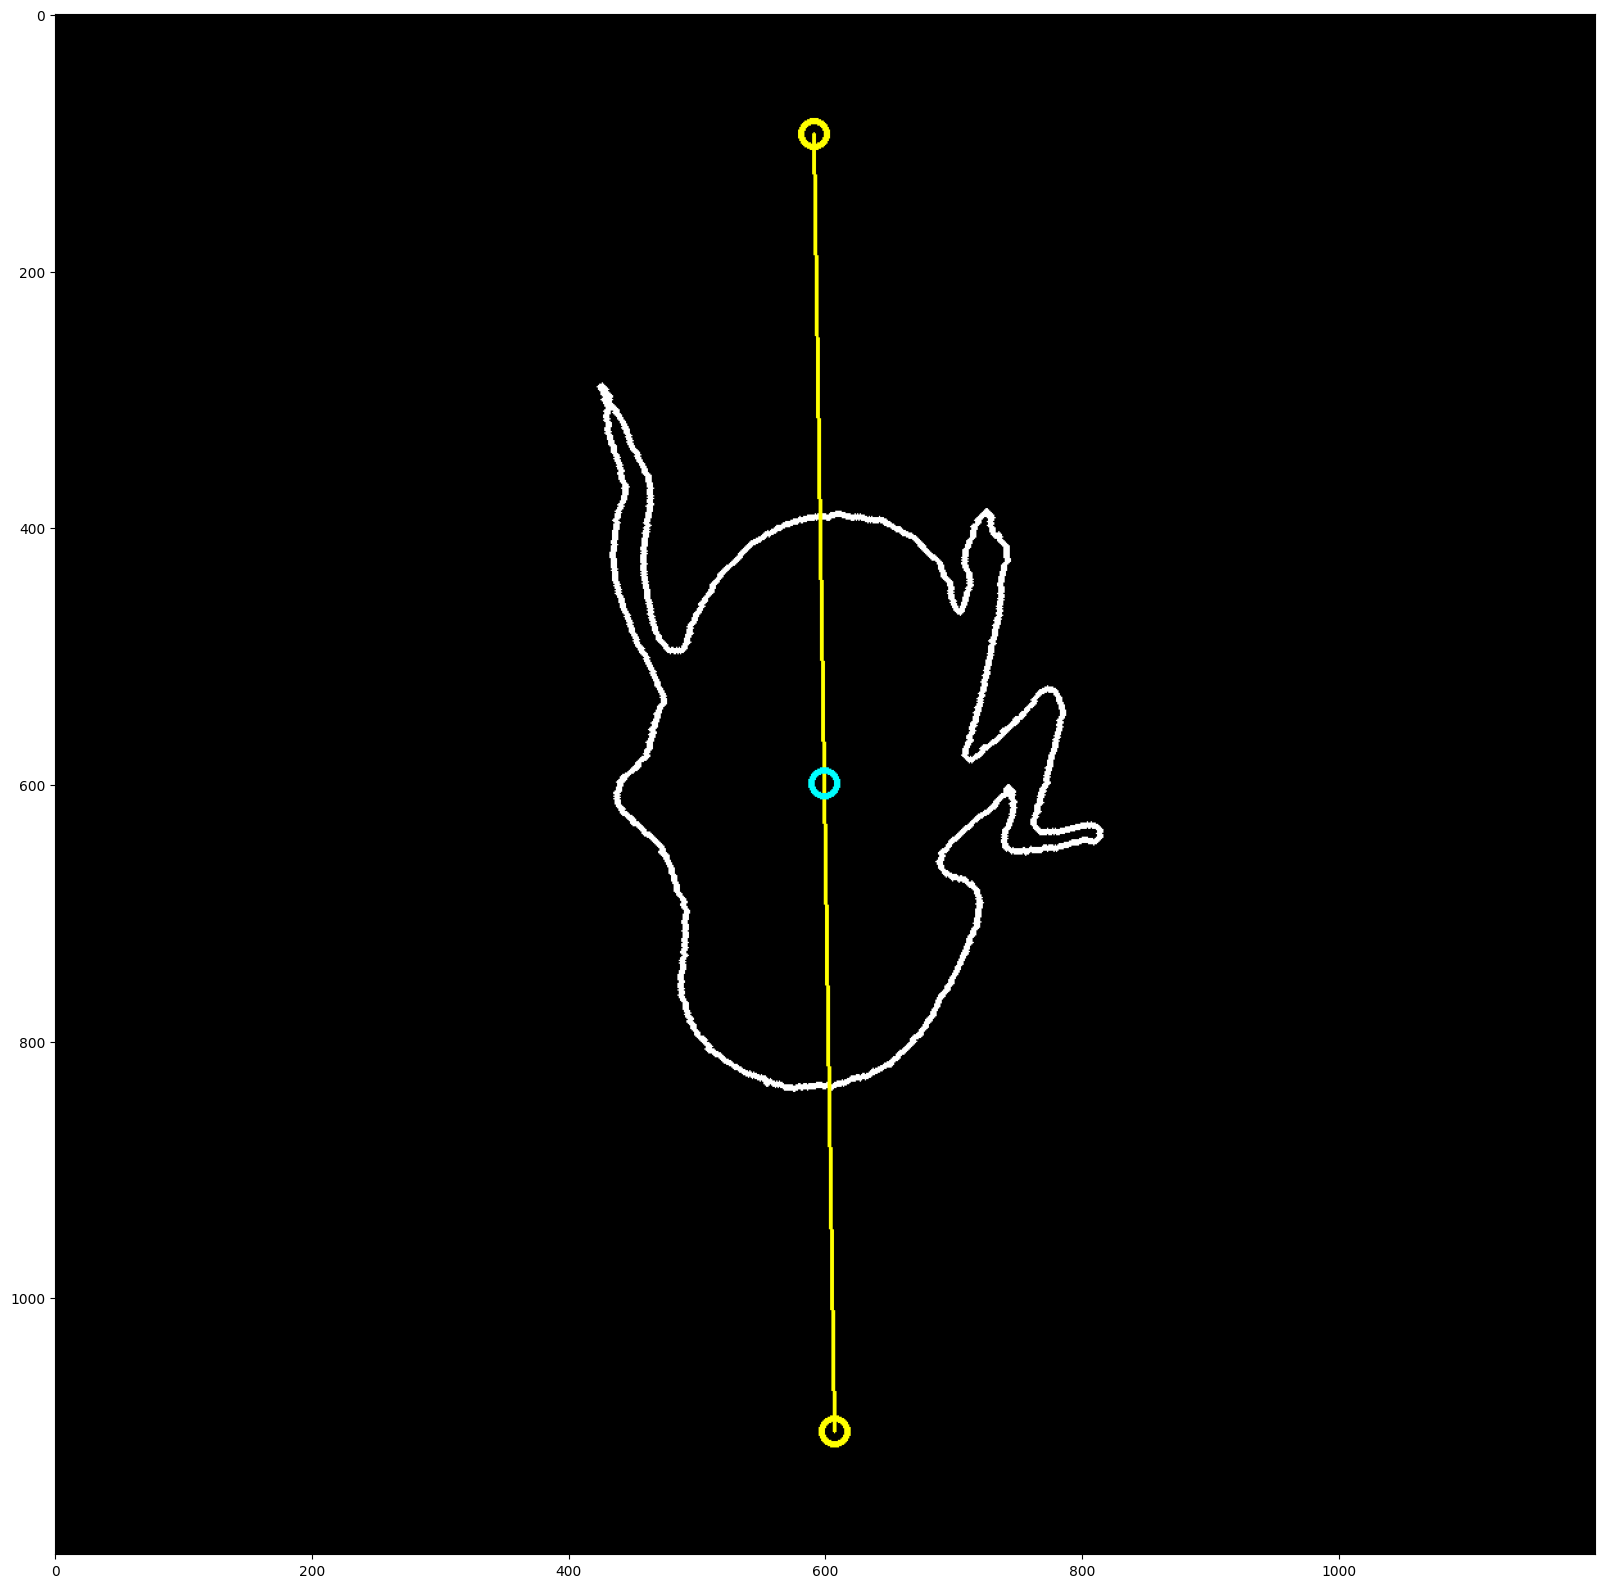

In [5]:
plt.figure(figsize=(20,20))
mask_fly = get_objectmask(fly_mask_hrz,max_contour_hrz)

cv2.circle(mask_fly,body_axis_pt_0_hrz,10, color = (255,255,0),thickness =3)
cv2.circle(mask_fly,body_axis_pt_1_hrz,10, color = (255,255,0),thickness =3)
cv2.line(mask_fly,body_axis_pt_0_hrz,body_axis_pt_1_hrz,color = (255,255,0), thickness = 2)
cv2.circle(mask_fly,centroid_hrz,10,color = (0,255,255),thickness=3)
plt.imshow(mask_fly)

## Labeling
After verifying that your dependancies are working, proceed to label 20 random images of flies from the path provided initially. The labeling process is to assign each image an indication of whether or not the Non Rotated or Rotated image best represents a Fly.

Three Images will be displayed, with the first image represeting the original fly orientation, the second the rotated and transformed fly based on it's orientation (which will allow it to be oriented along the central vertical axis). The last image is a subsequent 180 degree rotation of the fly after the initial rotation and transformation....

Essentially the labeling is a selection between the last two images. After making this selection that image will be saved in order to generate an average mask.

The Criteria for Labeling:
- Fly head facing up in an image then use the respective 'n' or 'r' to assign that image to the fly. with `n` corresponding to `No Rotation` and `r` corresponding to `Rotation`

In [6]:
imgs = {}
import time
import glob
import random
def img_label(filename):
    """
    For each image we will need to ensure that the proper rotation is performed such that it is in the 
    top down rotation
    
    """
    fly_mask_orig, fly_mask_hrz,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz,angle_og,angle_rot= contour_hrz_matrix(filename)
# mask_fly_norot = get_objectmask(fly_mask_hrz,max_contour_hrz)
    mask_fly_rot = cv2.rotate(copy.deepcopy(fly_mask_hrz),cv2.ROTATE_180)
    dict_img ={
        "n": fly_mask_hrz,
        "r":mask_fly_rot
    }
#     for i in range(1):
    ## test various rotations (0 or 180)
    fig = plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(fly_mask_orig,cmap='gray')
    print(f"<< Original Angle: {polarplt.deg360to180(np.rad2deg(angle_og))} >>")
    plt.subplot(1,3,2)
    plt.title("No Rotation")
    # print("No Rotation Angle:",np.rad2deg(angle))
    print(f"<< No Rotation Angle: {polarplt.deg360to180(np.rad2deg(angle_og))} >>")
    plt.imshow(fly_mask_hrz,cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Rotation")
    print(f"<< Rotation Angle: {polarplt.deg360to180(np.rad2deg(angle_og)-180)} >>")
    plt.imshow(mask_fly_rot,cmap='gray')
    plt.show()
    
    fly_up = input("Input the name of No Rotation or Rotation depending on which one display fly pointed up. ")
    mask_fly = dict_img[fly_up]
    
    return mask_fly

['/media/loganrower/D5E2-7968/20240502125110/20240502125110_7920.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_6931.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_1445.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_2247.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_3579.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_4346.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_5164.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_2018.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_6901.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_7009.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_8152.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_4494.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_2106.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_1198.png', '/media/loganrower/

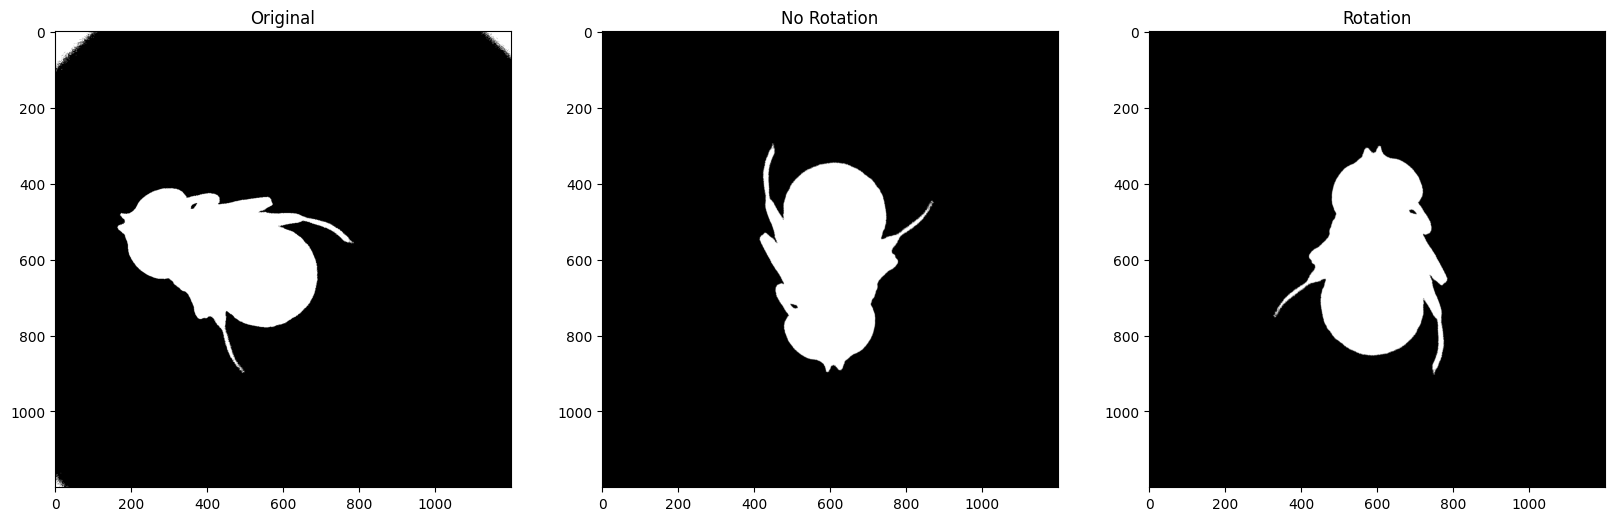

Angle Test!
Angle Value: 53.64463744510014
My Angle Value: 287.28927489020026
Angle Test!
Angle Value: 90.07938667489745
My Angle Value: 0.15877334979487046
<< Original Angle: 53.644637445100166 >>
<< No Rotation Angle: 53.644637445100166 >>
<< Rotation Angle: -126.35536255489984 >>


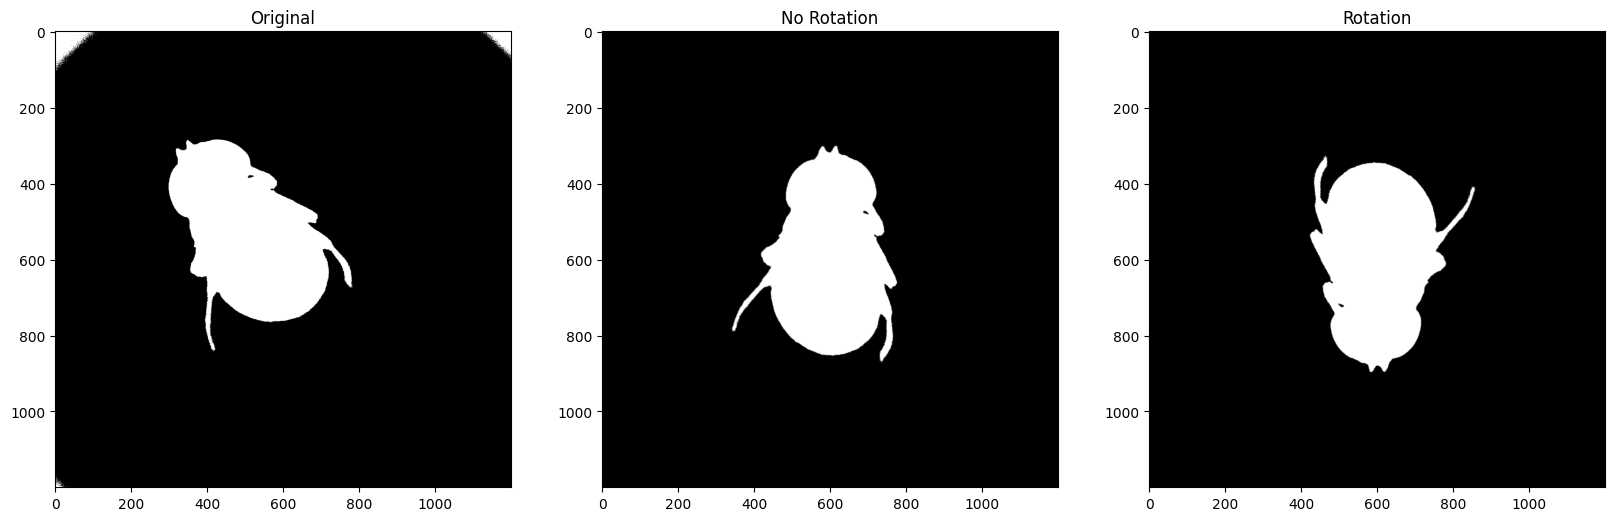

Angle Test!
Angle Value: 51.224595177556736
My Angle Value: 282.4491903551135
Angle Test!
Angle Value: 89.64322717444392
My Angle Value: 359.28645434888784
<< Original Angle: 51.22459517755672 >>
<< No Rotation Angle: 51.22459517755672 >>
<< Rotation Angle: -128.77540482244328 >>


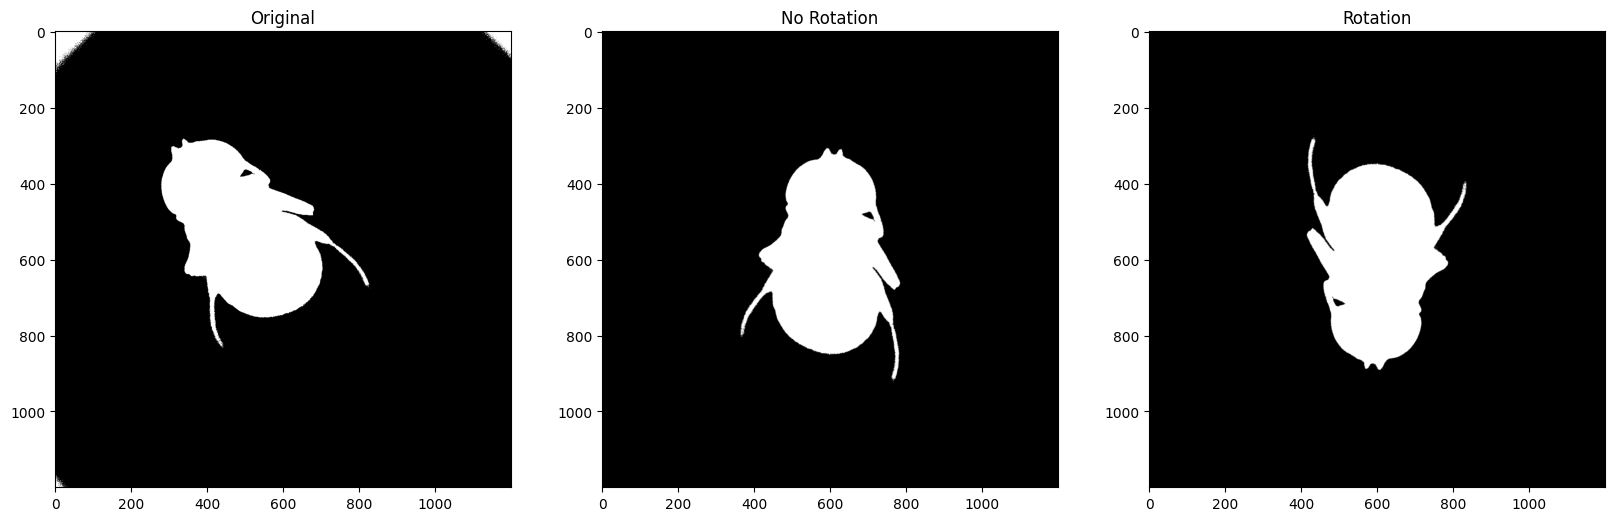

Angle Test!
Angle Value: 166.19608420413692
My Angle Value: 152.39216840827385
Angle Test!
Angle Value: 89.8543818602727
My Angle Value: 359.7087637205454
<< Original Angle: 166.19608420413692 >>
<< No Rotation Angle: 166.19608420413692 >>
<< Rotation Angle: -13.803915795863077 >>


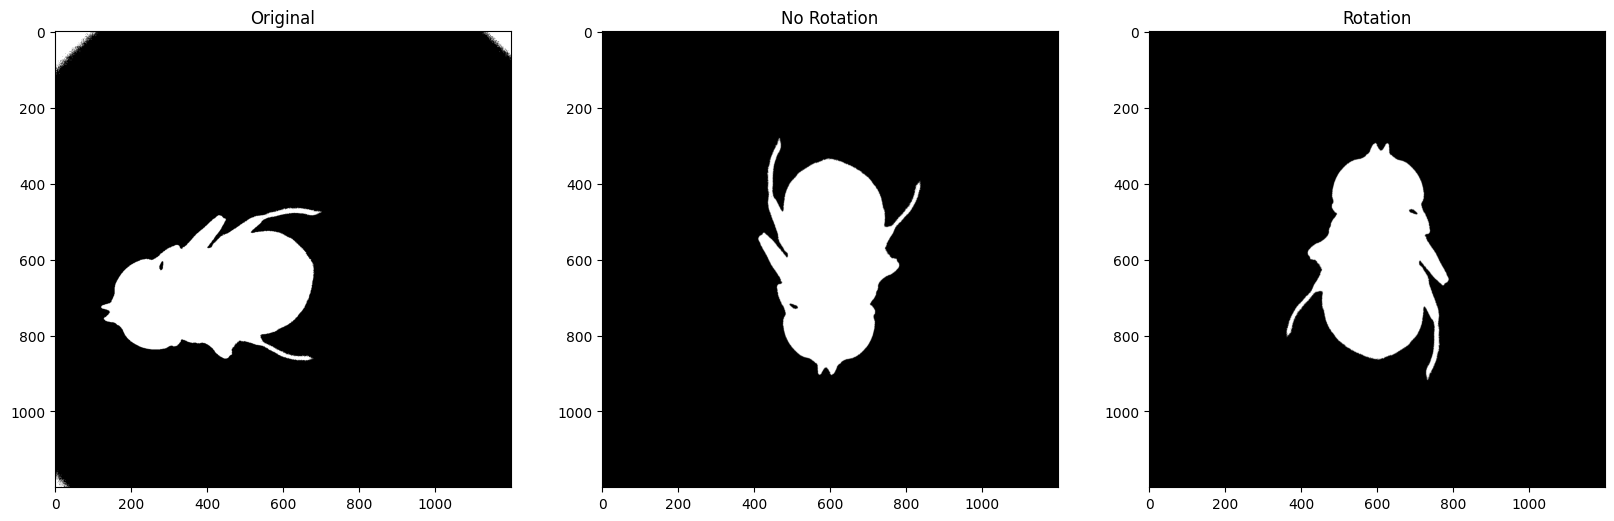

Angle Test!
Angle Value: 96.10261027985887
My Angle Value: 12.205220559717702
Angle Test!
Angle Value: 90.0908915461684
My Angle Value: 0.18178309233678647
<< Original Angle: 96.10261027985885 >>
<< No Rotation Angle: 96.10261027985885 >>
<< Rotation Angle: -83.89738972014118 >>


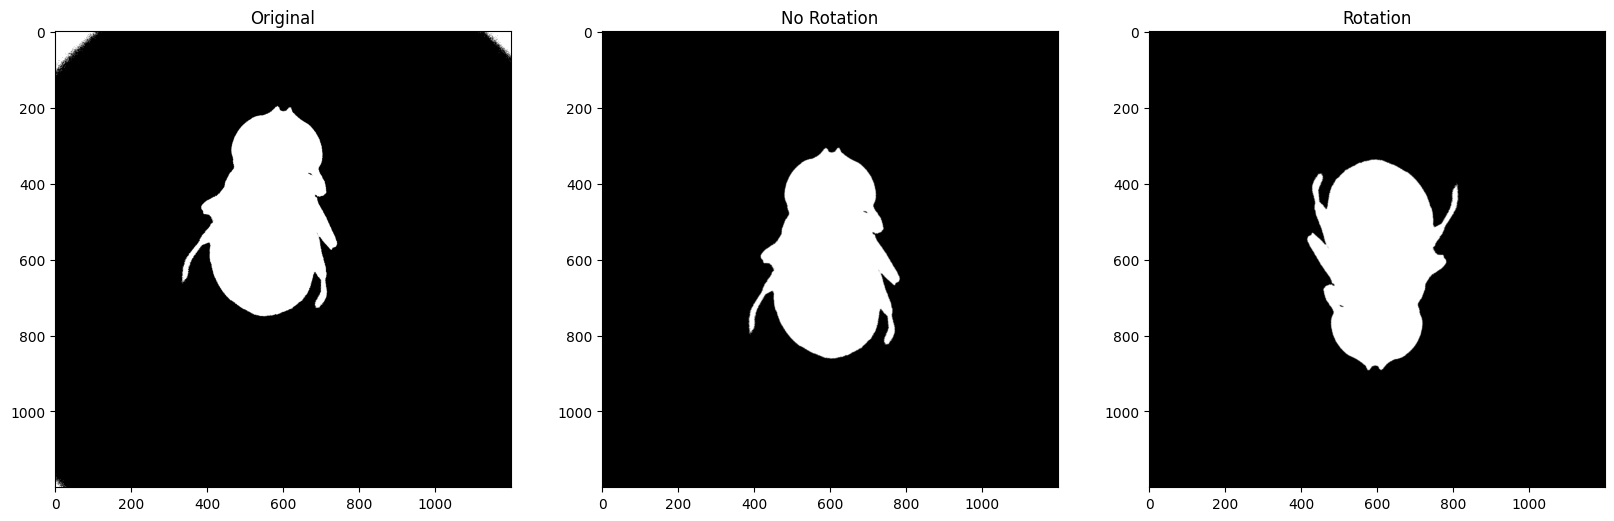

Angle Test!
Angle Value: 102.77261891185373
My Angle Value: 25.545237823707453
Angle Test!
Angle Value: 90.08074195758745
My Angle Value: 0.16148391517489813
<< Original Angle: 102.77261891185373 >>
<< No Rotation Angle: 102.77261891185373 >>
<< Rotation Angle: -77.22738108814627 >>


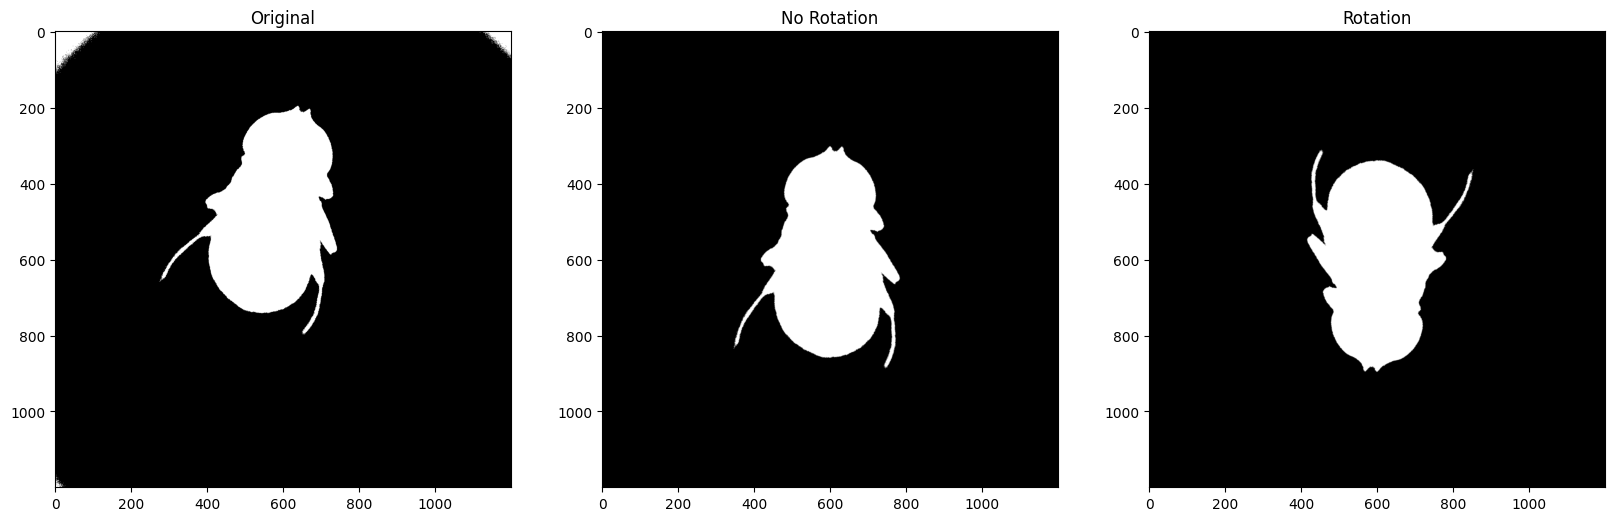

Angle Test!
Angle Value: 148.66991014934118
My Angle Value: 117.33982029868235
Angle Test!
Angle Value: 90.29990389839097
My Angle Value: 0.5998077967819029
<< Original Angle: 148.6699101493412 >>
<< No Rotation Angle: 148.6699101493412 >>
<< Rotation Angle: -31.330089850658794 >>


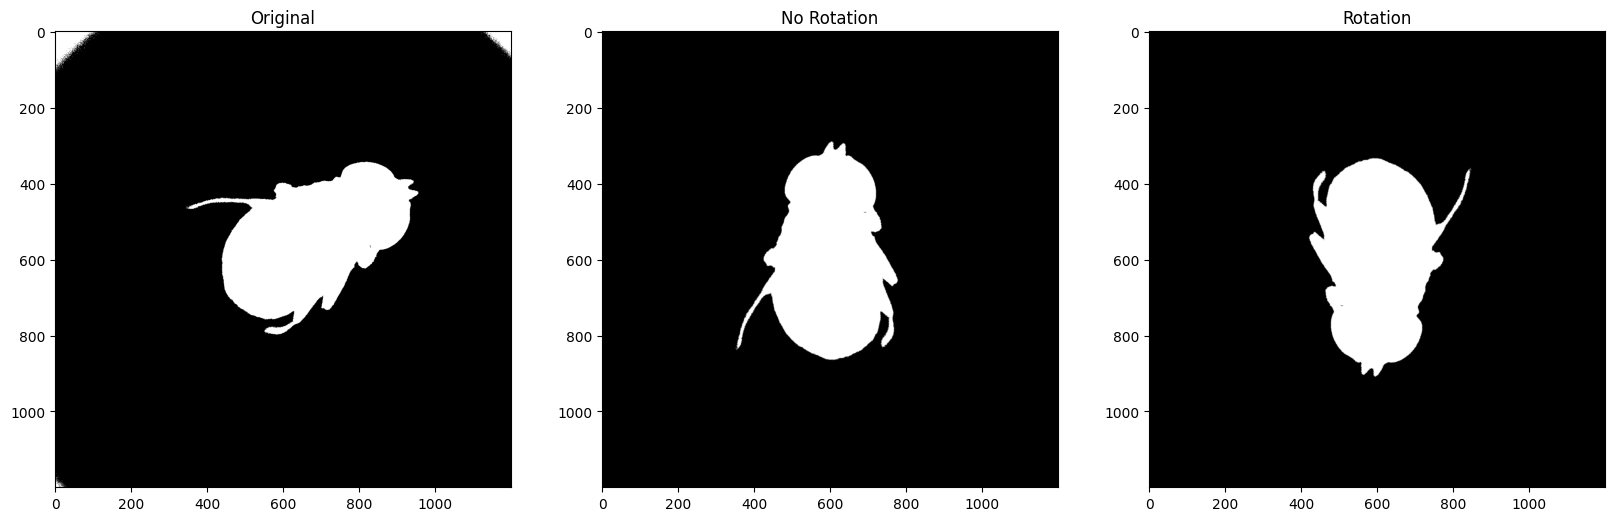

Angle Test!
Angle Value: 112.69221985895669
My Angle Value: 45.38443971791335
Angle Test!
Angle Value: 89.87127584501646
My Angle Value: 359.7425516900329
<< Original Angle: 112.69221985895669 >>
<< No Rotation Angle: 112.69221985895669 >>
<< Rotation Angle: -67.30778014104328 >>


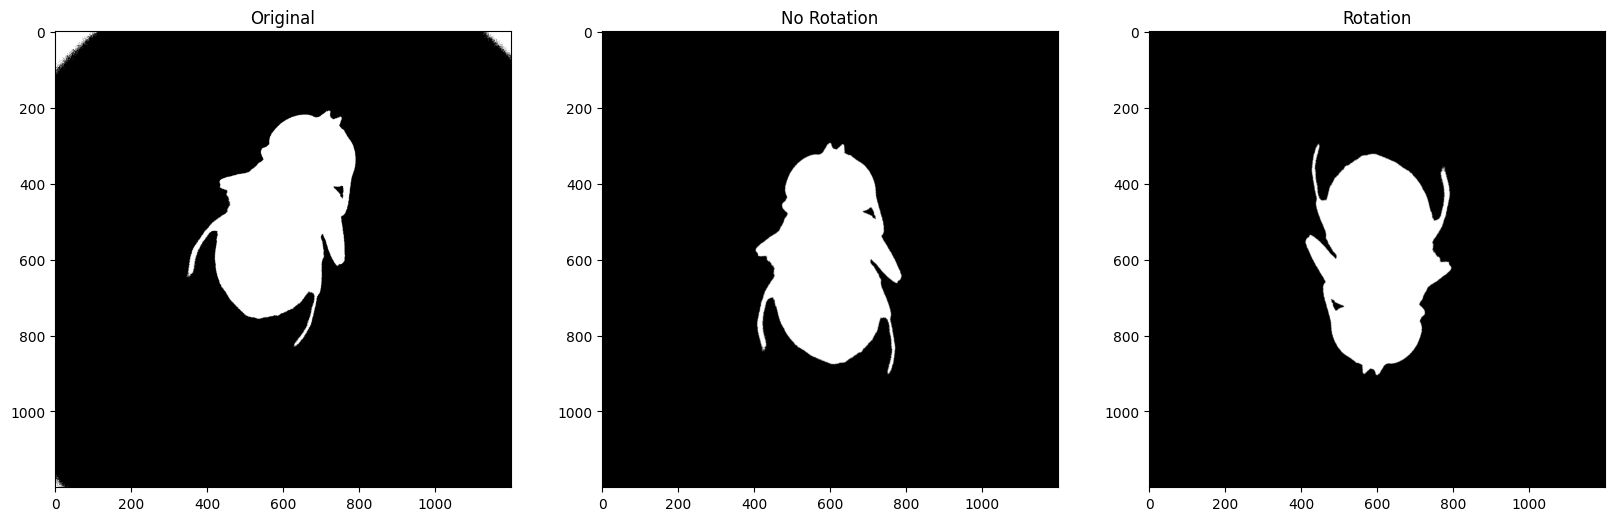

Angle Test!
Angle Value: 49.44960203169667
My Angle Value: 278.8992040633933
Angle Test!
Angle Value: 90.36087464678012
My Angle Value: 0.7217492935602365
<< Original Angle: 49.44960203169668 >>
<< No Rotation Angle: 49.44960203169668 >>
<< Rotation Angle: -130.55039796830332 >>


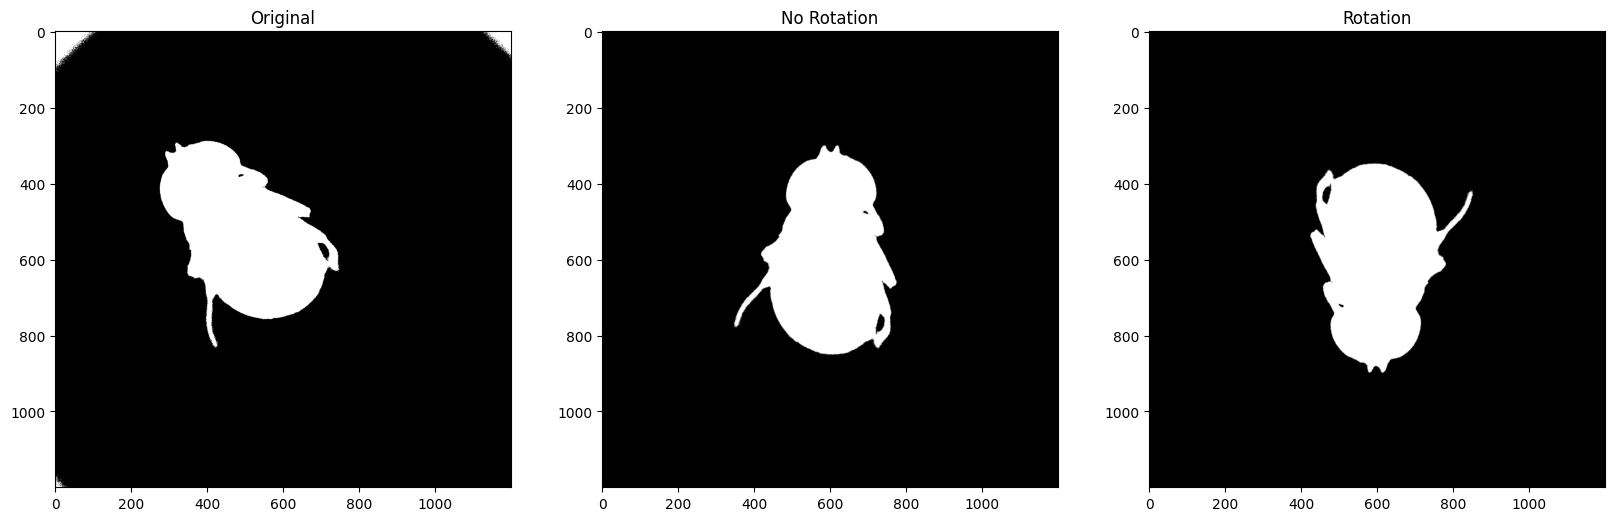

Angle Test!
Angle Value: 59.97456054970861
My Angle Value: 299.9491210994172
Angle Test!
Angle Value: 89.94542274368467
My Angle Value: 359.89084548736935
<< Original Angle: 59.9745605497086 >>
<< No Rotation Angle: 59.9745605497086 >>
<< Rotation Angle: -120.0254394502914 >>


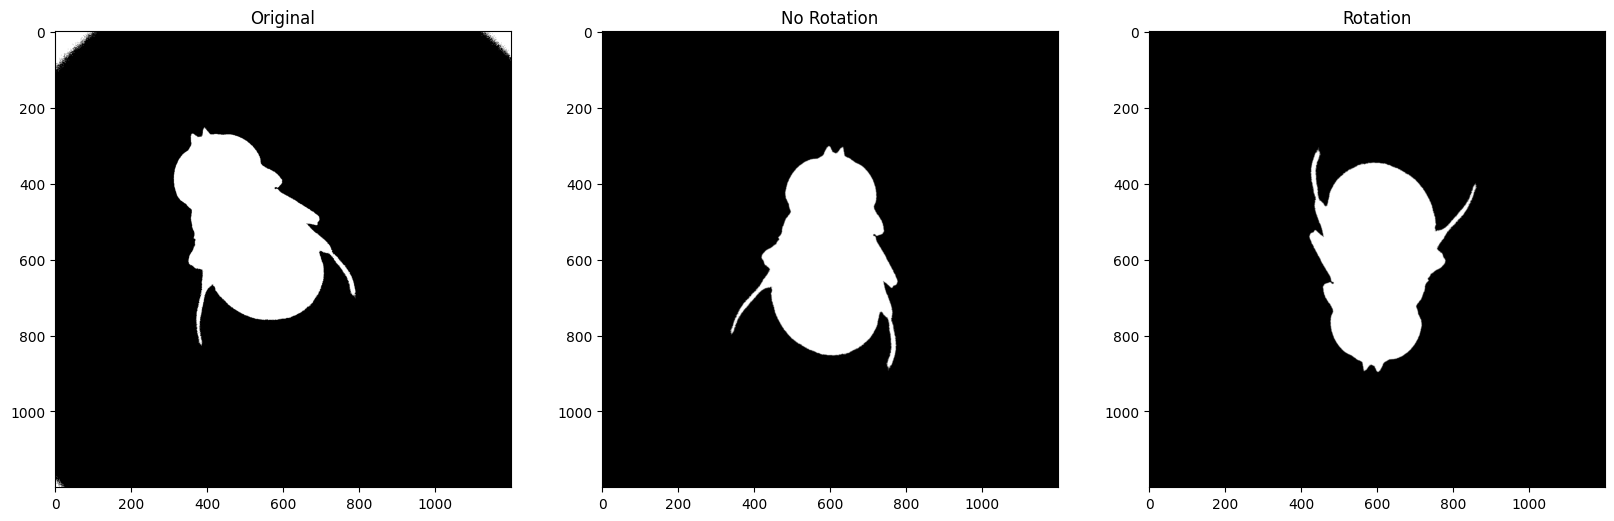

Angle Test!
Angle Value: 151.6788152355643
My Angle Value: 123.35763047112854
Angle Test!
Angle Value: 90.3683668856755
My Angle Value: 0.7367337713509983
<< Original Angle: 151.67881523556426 >>
<< No Rotation Angle: 151.67881523556426 >>
<< Rotation Angle: -28.32118476443577 >>


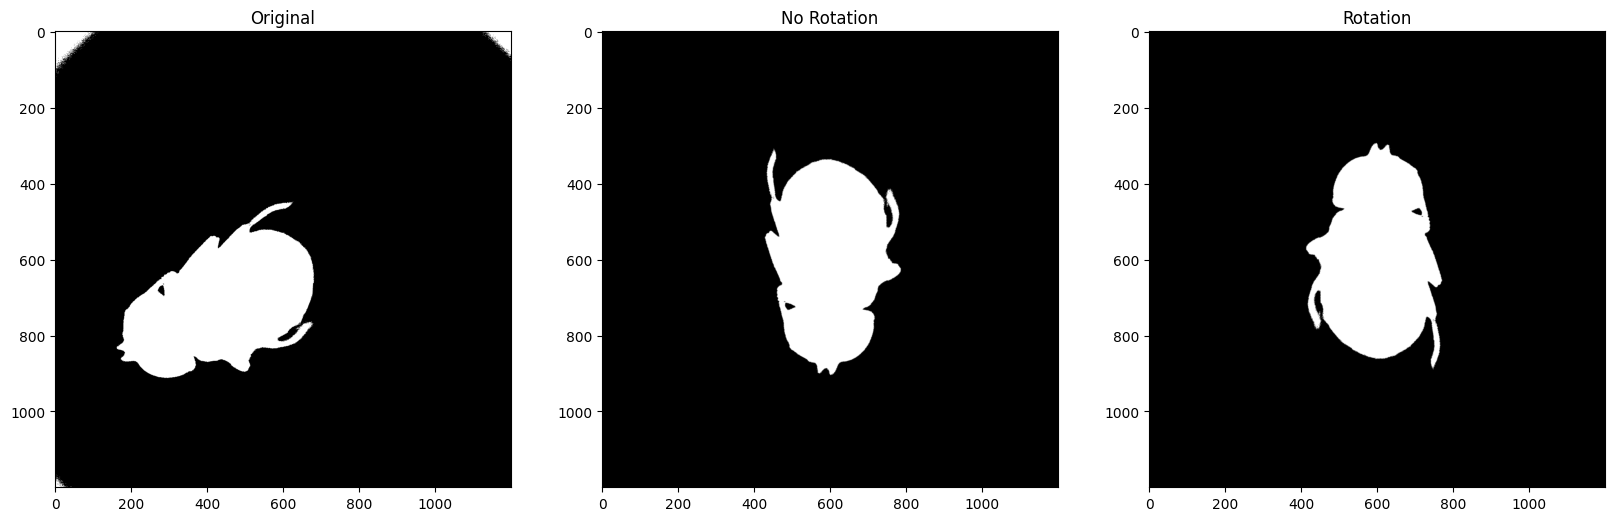

Angle Test!
Angle Value: 97.8535824098273
My Angle Value: 15.707164819654594
Angle Test!
Angle Value: 90.058199727257
My Angle Value: 0.11639945451398148
<< Original Angle: 97.85358240982728 >>
<< No Rotation Angle: 97.85358240982728 >>
<< Rotation Angle: -82.14641759017275 >>


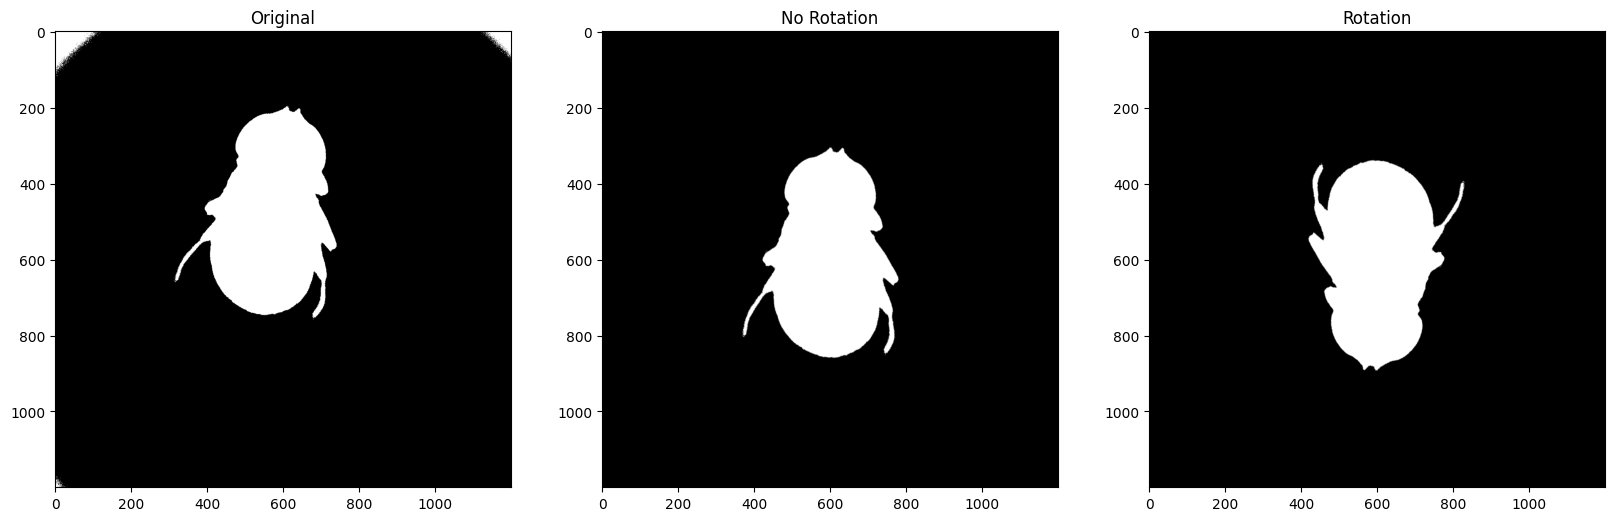

Angle Test!
Angle Value: -173.50664166691647
My Angle Value: 192.98671666616707
Angle Test!
Angle Value: 89.76592972253152
My Angle Value: 359.53185944506305
<< Original Angle: -173.50664166691647 >>
<< No Rotation Angle: -173.50664166691647 >>
<< Rotation Angle: 6.493358333083506 >>


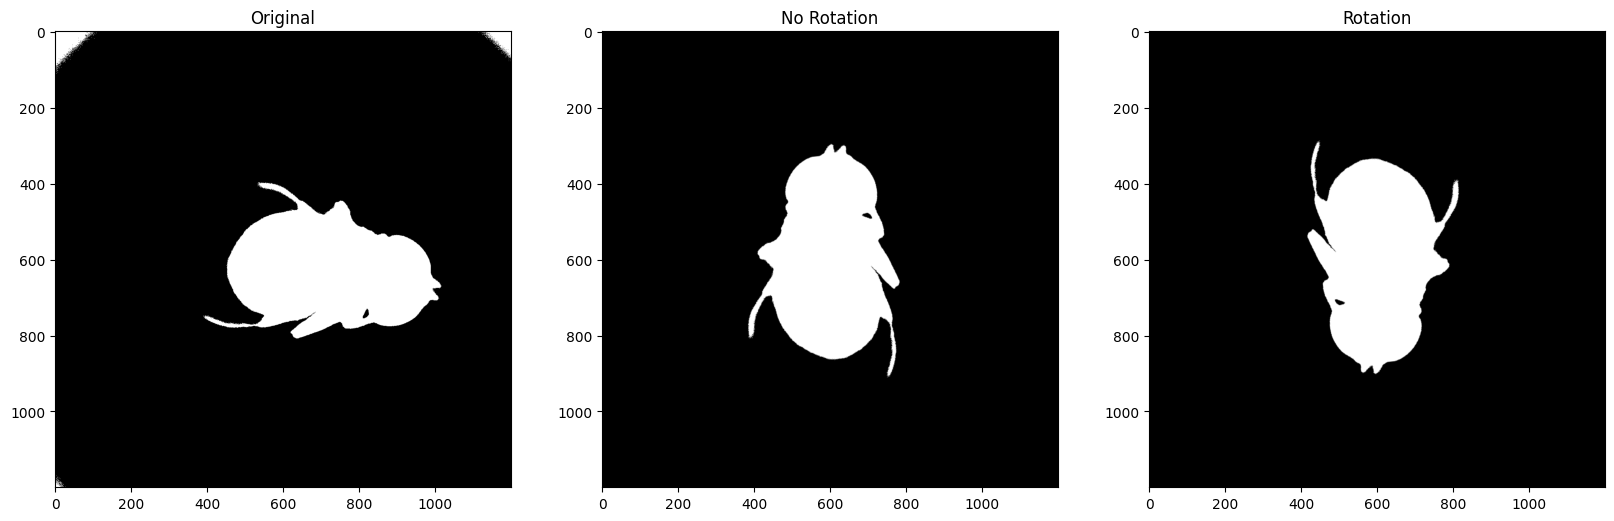

Angle Test!
Angle Value: 142.0117946594007
My Angle Value: 104.0235893188014
Angle Test!
Angle Value: 88.38314290578207
My Angle Value: 356.7662858115641
<< Original Angle: 142.01179465940072 >>
<< No Rotation Angle: 142.01179465940072 >>
<< Rotation Angle: -37.98820534059928 >>


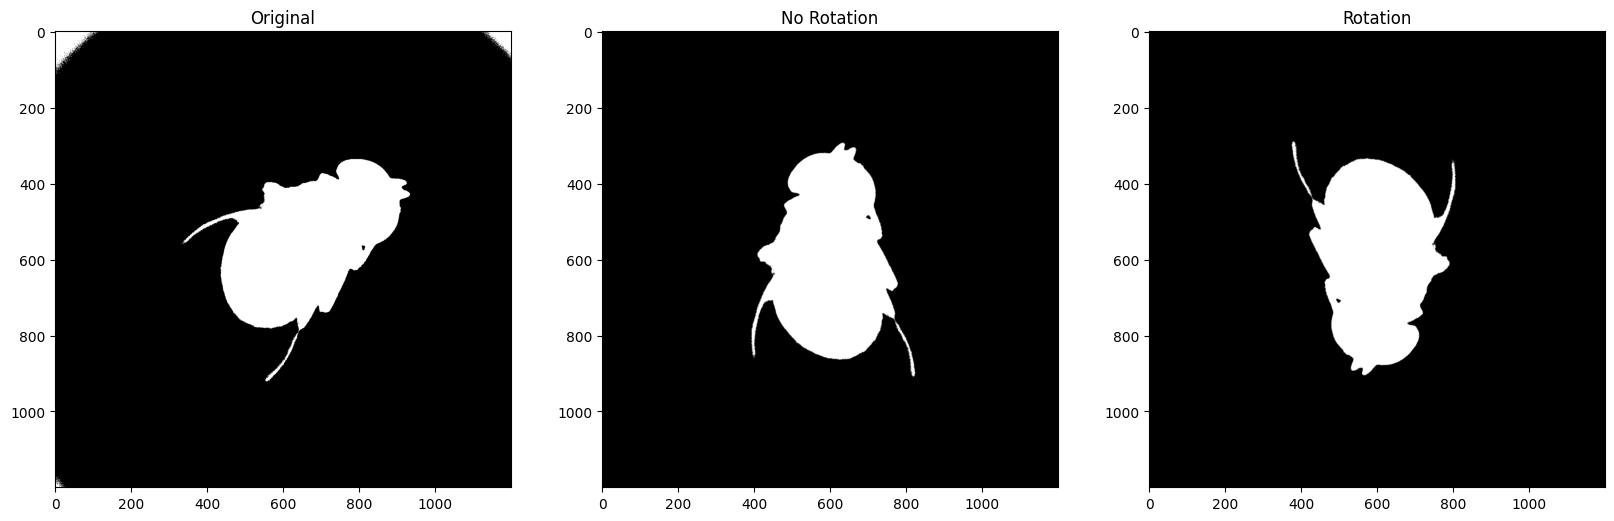

Angle Test!
Angle Value: -162.99896962912672
My Angle Value: 214.00206074174656
Angle Test!
Angle Value: 89.87812986446932
My Angle Value: 359.75625972893863
<< Original Angle: -162.99896962912672 >>
<< No Rotation Angle: -162.99896962912672 >>
<< Rotation Angle: 17.00103037087331 >>


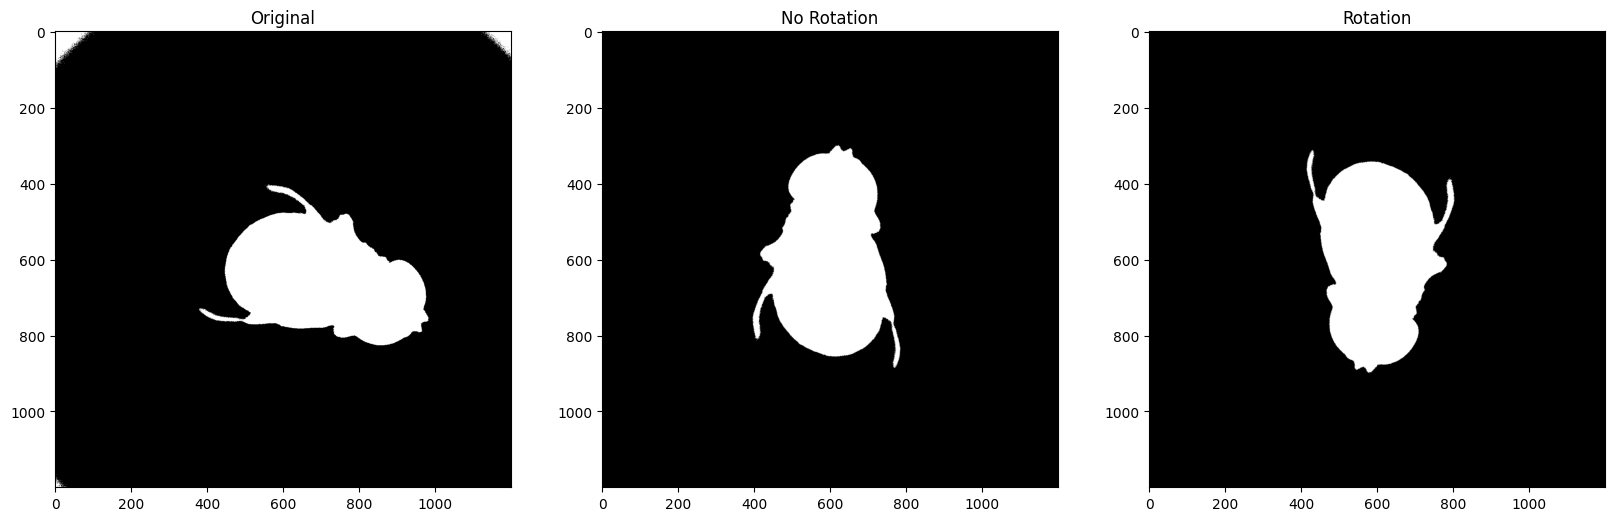

Angle Test!
Angle Value: 98.10337103175591
My Angle Value: 16.206742063511825
Angle Test!
Angle Value: 90.09524204107919
My Angle Value: 0.1904840821583491
<< Original Angle: 98.1033710317559 >>
<< No Rotation Angle: 98.1033710317559 >>
<< Rotation Angle: -81.8966289682441 >>


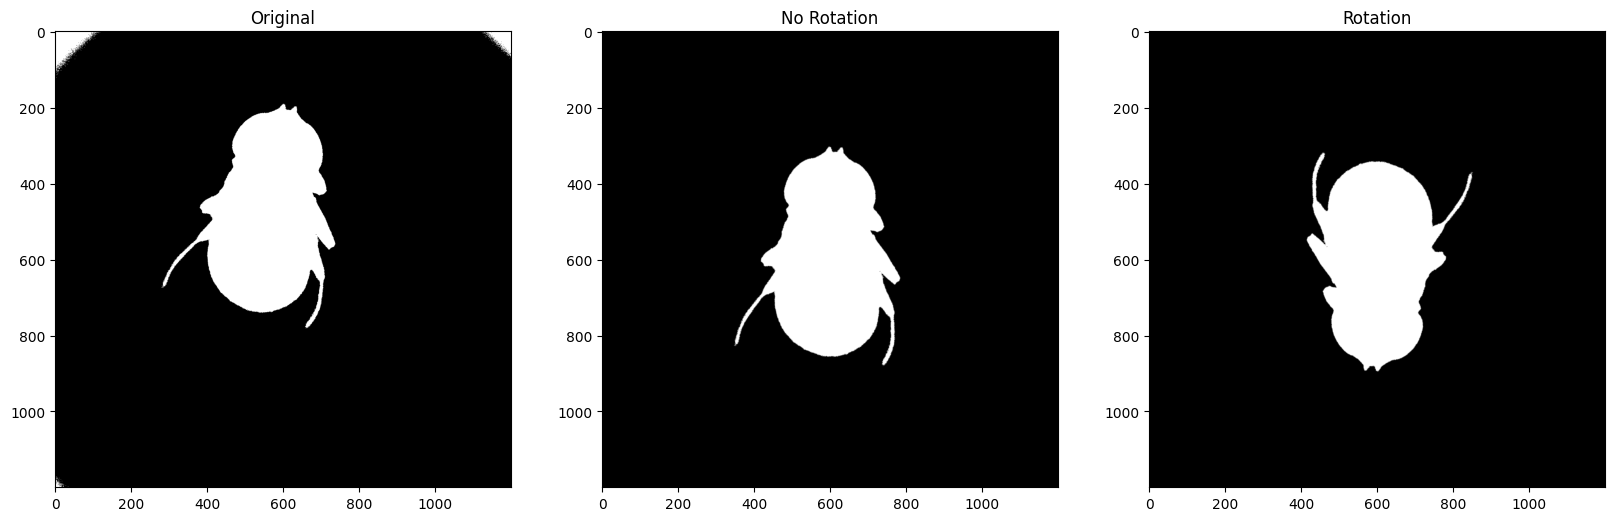

Angle Test!
Angle Value: 149.90247877256292
My Angle Value: 119.80495754512579
Angle Test!
Angle Value: 90.01339806151904
My Angle Value: 0.026796123038081987
<< Original Angle: 149.90247877256292 >>
<< No Rotation Angle: 149.90247877256292 >>
<< Rotation Angle: -30.097521227437085 >>


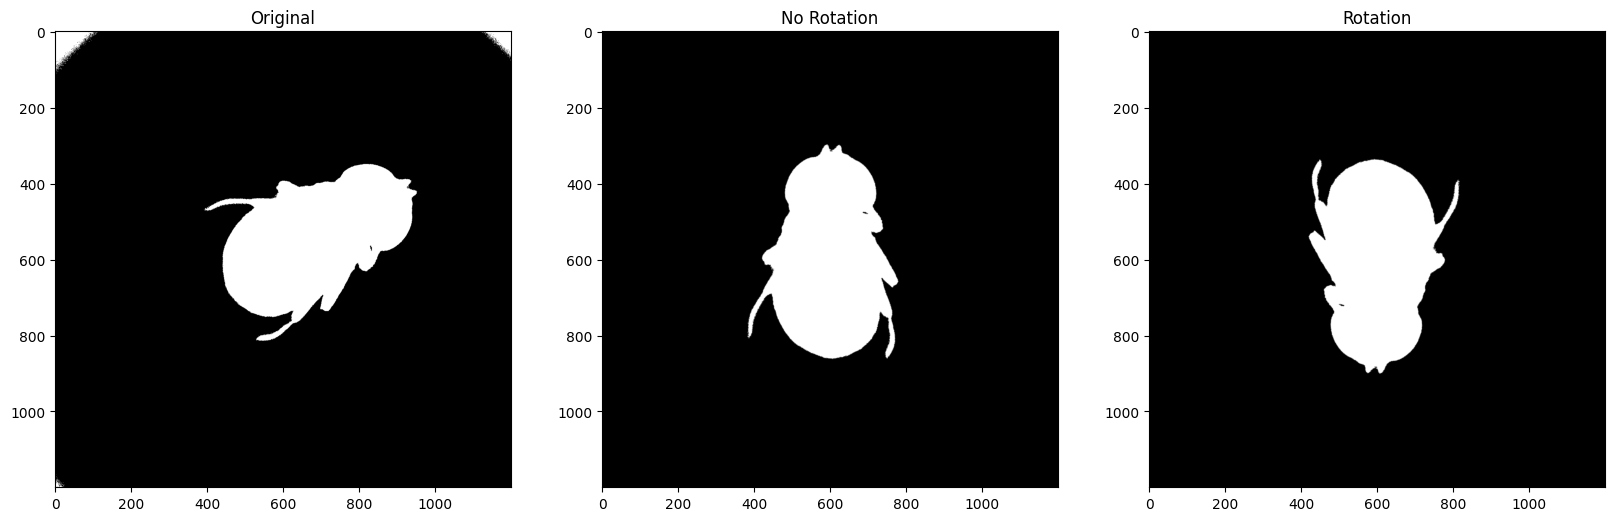

Angle Test!
Angle Value: 83.58301594856461
My Angle Value: 347.1660318971292
Angle Test!
Angle Value: 90.1458269578678
My Angle Value: 0.2916539157355942
<< Original Angle: 83.5830159485646 >>
<< No Rotation Angle: 83.5830159485646 >>
<< Rotation Angle: -96.4169840514354 >>


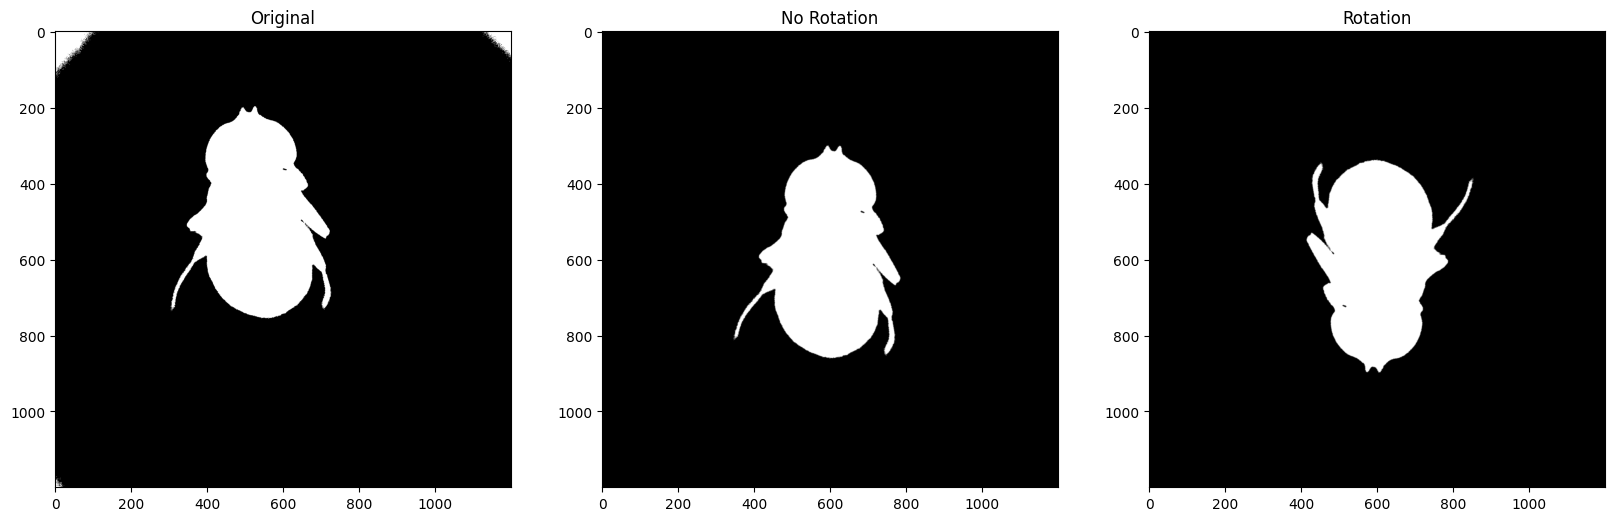

Angle Test!
Angle Value: 147.50600496694364
My Angle Value: 115.01200993388728
Angle Test!
Angle Value: 89.88911636754922
My Angle Value: 359.7782327350984
<< Original Angle: 147.50600496694364 >>
<< No Rotation Angle: 147.50600496694364 >>
<< Rotation Angle: -32.493995033056365 >>


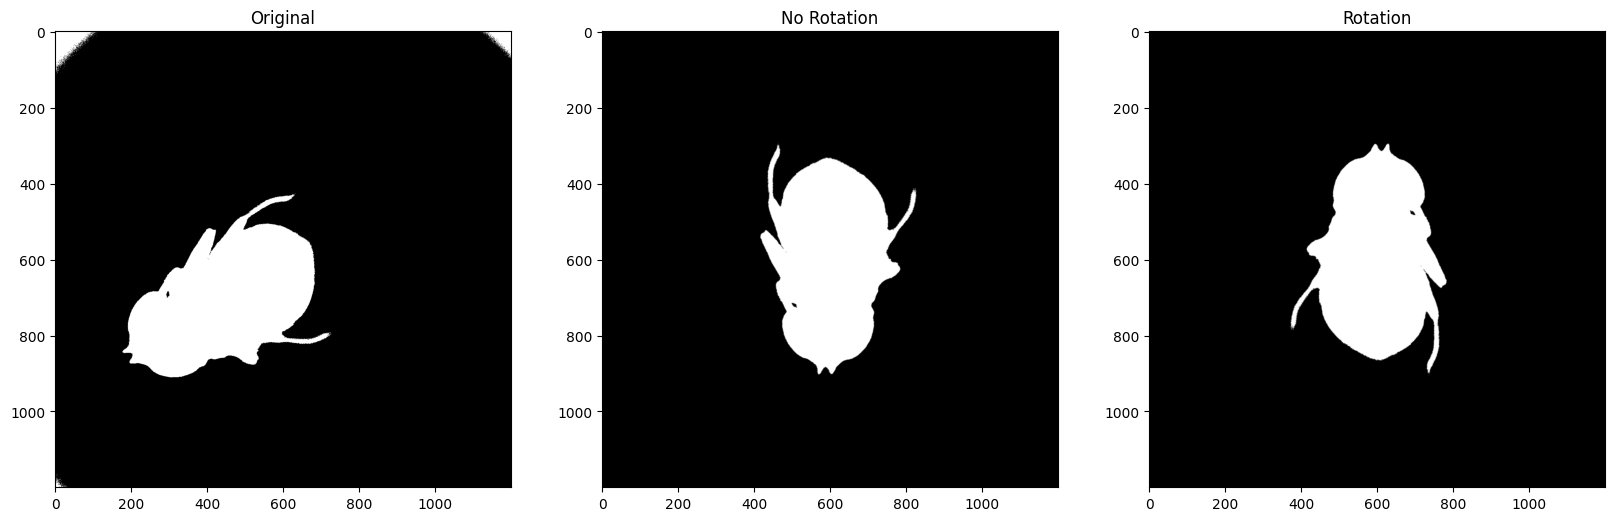

Angle Test!
Angle Value: 47.88198782961307
My Angle Value: 275.7639756592261
Angle Test!
Angle Value: 89.894954767532
My Angle Value: 359.789909535064
<< Original Angle: 47.88198782961305 >>
<< No Rotation Angle: 47.88198782961305 >>
<< Rotation Angle: -132.11801217038695 >>


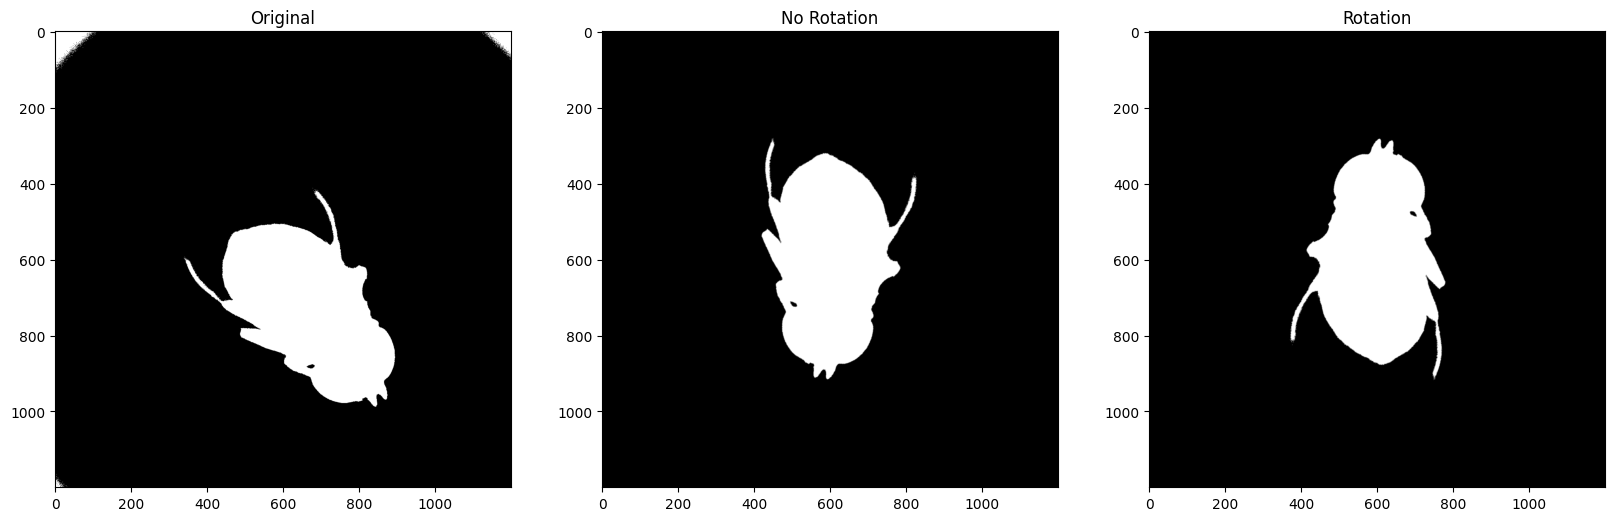

In [7]:
# get all of the files in the folder
# shuffled_list = sorted(glob.glob('/media/flyranch/T7 Shield/flyflipimgs/20240502125110/*.png'), key=lambda x: random.random())
shuffled_list = sorted(data, key=lambda x: random.random())
print(shuffled_list)
for file in shuffled_list[:20]:
    name = file.split('/')[-1].strip('.png')
    mask_fly = img_label(file)
    imgs[name] = mask_fly
    # execute function and then add these images and etc to the dictionary

## Average Fly Mask Template 
Using the 20 labelled images, a grayscale template mask will be developed of the fly facing upward. This average mask will then be tested against all images in the dataset to determine correct orientation.

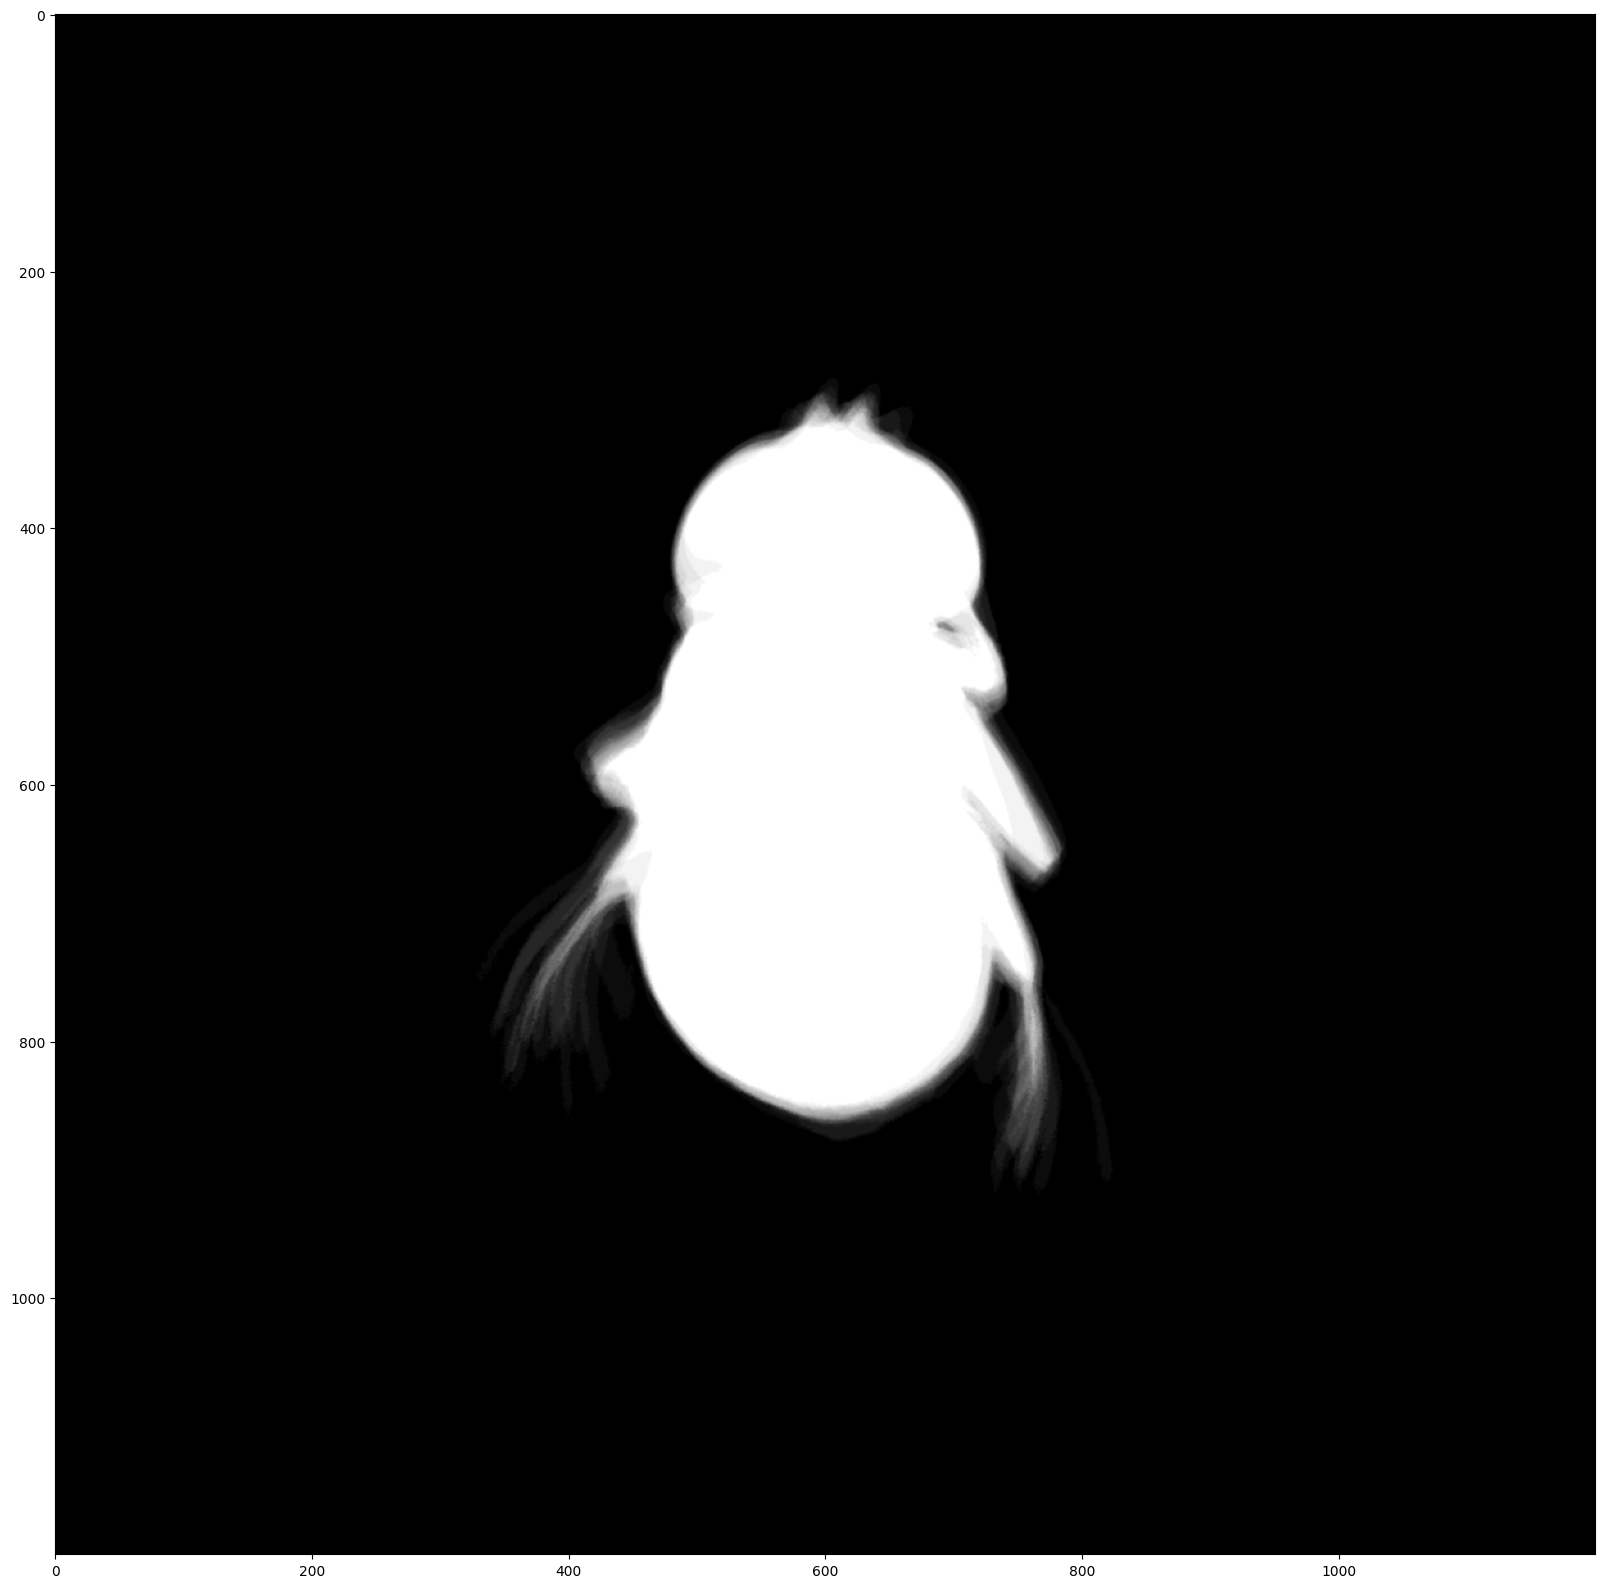

In [8]:
### Now with all the images we will create a mean tempate mask
final = []
for img in imgs.keys():
    final.append(imgs[img])
# print(final)
stacked = np.stack(final,axis=-1)
avg_mask = np.mean(stacked, axis = -1)
plt.figure(figsize=(20,20))
plt.imshow(avg_mask,cmap = 'gray')

## MSE Comparison
The entire image dataset will be tested against this average mask to determine the correct orientation of the fly. The MSE Rot and MSE No Rot will be logged as well as whether fly is No Rot or Rot.

In [211]:
## Comparison between two images
def mse(img1, img2):
    area_px = img1.shape[0]*img1.shape[1]
    px_diff = cv2.subtract(img1, img2)
    sum_err = np.sum(px_diff**2)
    mse = sum_err/(float(area_px))
    return mse
def data_mse(data):
    data_results = {
        "file":[],
        "type":[],
        "MSE":[],
        "Original Angle":[],
        "Adjusted Angle":[]
    }
    for file in data:
        name = file.split('/')[-1].strip('.png')
        mask_fly= contour_hrz_matrix(file)[1].astype(float)
        angle_og = contour_hrz_matrix(file)[6]
        ## No Rotation or Rotation
        d = {
            "MSE No Rotation":mse(avg_mask,mask_fly),
            "MSE Rotation": mse(avg_mask,cv2.rotate(mask_fly,cv2.ROTATE_180))
        }
        # print(d)
        
        ## Save the min MSE Value
        data_results["file"].append(name)
        img_rot_type = list(d.keys())[list(d.values()).index(min(list(d.values())))]
        if img_rot_type == "MSE No Rotation":
            angle_og_deg= polarplt.deg360to180(np.rad2deg(angle_og))
            angle_adj = polarplt.deg360to180(np.rad2deg(angle_og))
        else:
            angle_og_deg = polarplt.deg360to180(np.rad2deg(angle_og))
            angle_adj = polarplt.deg360to180(np.rad2deg(angle_og)-180)

        data_results['type'].append(img_rot_type)
        data_results["MSE"].append((d["MSE No Rotation"],d["MSE Rotation"])) # both MSE values...
        data_results['Original Angle'].append(angle_og_deg)
        data_results['Adjusted Angle'].append(angle_adj)
        print("----------------")
    return data_results


In [212]:
imgs[list(imgs.keys())[0]].dtype
img1 = imgs[list(imgs.keys())[18]].astype('float64')
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 213.11708025868055
Rotation: 1205.7547729670143


In [213]:
np.random.choice(data)

'/media/loganrower/D5E2-7968/20240502125110/20240502125110_7480.png'

In [242]:
fly_mask_orig1, fly_mask_hrz1,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz,angle_og,angle_rot= contour_hrz_matrix(('/media/loganrower/D5E2-7968/20240502125110/20240502125110_0008.png'))
img1 = fly_mask_hrz1.astype('float64')
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("------------")
print(angle_og)
print(np.rad2deg(angle_og))
print(polarplt.deg360to180(np.rad2deg(angle_og)-180))


Angle Test!
Angle Value: -151.56315612336587
My Angle Value: 236.87368775326829
Angle Test!
Angle Value: 89.95270842557198
My Angle Value: 359.90541685114397
------------
-2.6452760990669395
-151.56315612336587
28.436843876634157


<< Original Angle: -151.56315612336587 >>
<< No Rotation Angle: -151.56315612336587 >>
<< Rotation Angle: 28.436843876634157 >>


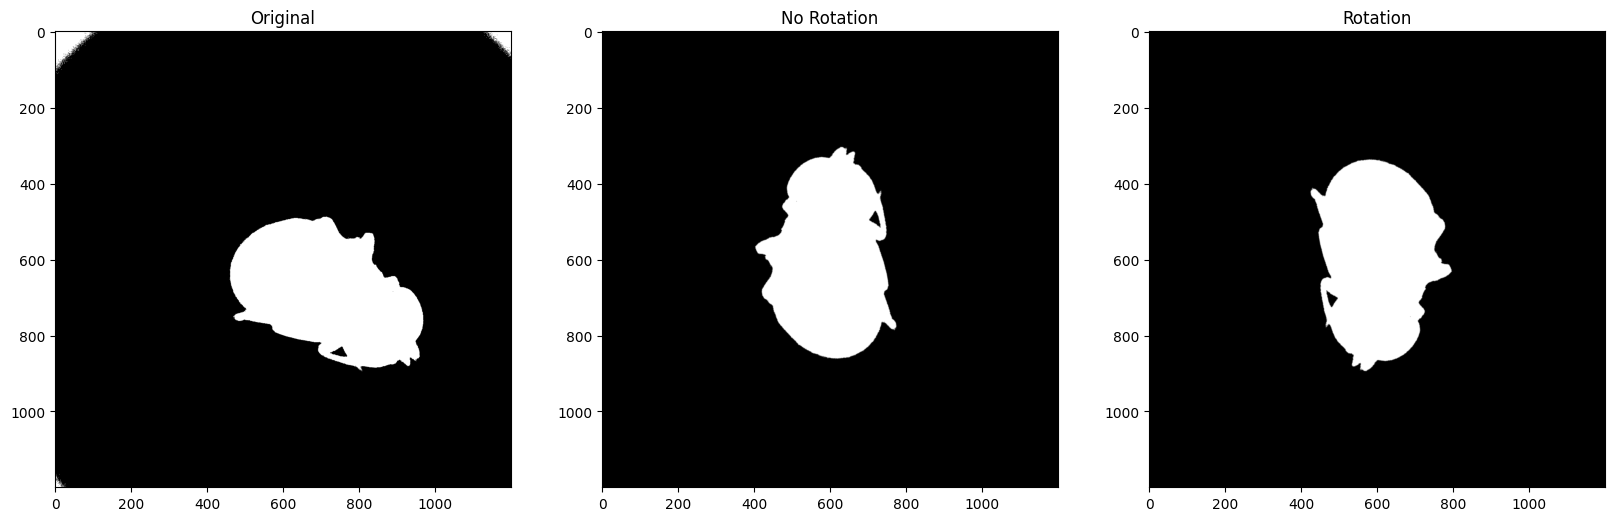

In [243]:
mask_fly_rot1 = cv2.rotate(copy.deepcopy(fly_mask_hrz1),cv2.ROTATE_180)

fig = plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(fly_mask_orig1,cmap='gray')
print(f"<< Original Angle: {np.rad2deg(angle_og)} >>")
plt.subplot(1,3,2)
plt.title("No Rotation")
# print("No Rotation Angle:",np.rad2deg(angle))
print(f"<< No Rotation Angle: {np.rad2deg(angle_og)} >>")
plt.imshow(fly_mask_hrz1,cmap='gray')
plt.subplot(1,3,3)
plt.title("Rotation")
print(f"<< Rotation Angle: {polarplt.deg360to180(np.rad2deg(angle_og)-180)} >>")
plt.imshow(mask_fly_rot1,cmap='gray')
plt.show()

In [245]:
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 429.4627531059028
Rotation: 1075.2394194253477


The `data_mse` function can take from 10-15 min based on size of the dataset.

In [217]:
results = data_mse(data)
results

Angle Test!
Angle Value: -151.56315612336587
My Angle Value: 236.87368775326829
Angle Test!
Angle Value: 89.95270842557198
My Angle Value: 359.90541685114397
Angle Test!
Angle Value: -151.56315612336587
My Angle Value: 236.87368775326829
Angle Test!
Angle Value: 89.95270842557198
My Angle Value: 359.90541685114397
----------------
Angle Test!
Angle Value: 171.74574168845953
My Angle Value: 163.49148337691906
Angle Test!
Angle Value: 89.86981333873817
My Angle Value: 359.73962667747634
Angle Test!
Angle Value: 171.74574168845953
My Angle Value: 163.49148337691906
Angle Test!
Angle Value: 89.86981333873817
My Angle Value: 359.73962667747634
----------------
Angle Test!
Angle Value: 145.2359769345717
My Angle Value: 110.47195386914338
Angle Test!
Angle Value: 89.75972890132275
My Angle Value: 359.5194578026455
Angle Test!
Angle Value: 145.2359769345717
My Angle Value: 110.47195386914338
Angle Test!
Angle Value: 89.75972890132275
My Angle Value: 359.5194578026455
----------------
Angle Tes

{'file': ['20240502125110_0008',
  '20240502125110_0011',
  '20240502125110_0024',
  '20240502125110_0026',
  '20240502125110_0027',
  '20240502125110_0029',
  '20240502125110_0031',
  '20240502125110_0041',
  '20240502125110_0046',
  '20240502125110_0052',
  '20240502125110_0062',
  '20240502125110_0104',
  '20240502125110_0105',
  '20240502125110_0138',
  '20240502125110_0192',
  '20240502125110_0203',
  '20240502125110_0209',
  '20240502125110_0212',
  '20240502125110_0215',
  '20240502125110_0230',
  '20240502125110_0235',
  '20240502125110_0240',
  '20240502125110_0258',
  '20240502125110_0259',
  '20240502125110_0265',
  '20240502125110_0292',
  '20240502125110_0296',
  '20240502125110_0306',
  '20240502125110_0307',
  '20240502125110_0311',
  '20240502125110_0330',
  '20240502125110_0351',
  '20240502125110_0370',
  '20240502125110_0376',
  '20240502125110_0407',
  '20240502125110_0410',
  '20240502125110_0415',
  '20240502125110_0422',
  '20240502125110_0423',
  '20240502125110

The dictionary is then transformed into a dataframe for additional processing and subsequent plotting

In [218]:
results_df = pd.DataFrame(results)
results_df.head()

file             type  \
0  20240502125110_0008  MSE No Rotation   
1  20240502125110_0011     MSE Rotation   
2  20240502125110_0024     MSE Rotation   
3  20240502125110_0026     MSE Rotation   
4  20240502125110_0027     MSE Rotation   

                                        MSE  Original Angle  Adjusted Angle  
0   (429.4627531059028, 1075.2394194253477)     -151.563156     -151.563156  
1  (1203.8725097031252, 399.16644081423624)      171.745742       -8.254258  
2  (1338.7261300503471, 441.92091518923615)      145.235977      -34.764023  
3  (1353.7941060225696, 438.20983199479156)     -175.968158        4.031842  
4  (1381.6763597725699, 460.42051136979165)     -156.853924       23.146076

# Plot all data

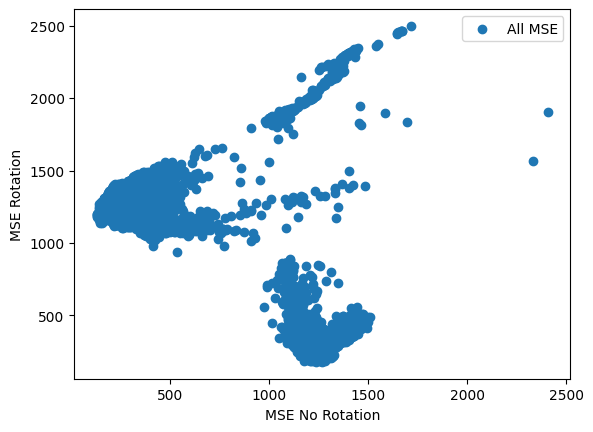

In [219]:
plt.scatter(results_df['MSE'].apply(lambda x: x[0]),results_df['MSE'].apply(lambda x: x[1]),label = 'All MSE')
plt.xlabel('MSE No Rotation')
plt.ylabel('MSE Rotation')
plt.legend()

## Plot of MSE ERROR No Rotation vs Rotation for Large Dataset

Using the average mask from before we will now look at all the images in the dataset to determine accuracy. 

In [244]:
results_df.head(10)

file             type  \
0  20240502125110_0001  MSE No Rotation   
1  20240502125110_0002  MSE No Rotation   
2  20240502125110_0003  MSE No Rotation   
3  20240502125110_0004  MSE No Rotation   
4  20240502125110_0005  MSE No Rotation   
5  20240502125110_0006  MSE No Rotation   
6  20240502125110_0007  MSE No Rotation   
7  20240502125110_0008  MSE No Rotation   
8  20240502125110_0009     MSE Rotation   
9  20240502125110_0010     MSE Rotation   

                                        MSE  Original Angle  Adjusted Angle  \
0   (662.3484944253474, 1451.3111565781255)      110.494410      110.494410   
1   (588.8039388697915, 1456.2091649114582)      122.725043      122.725043   
2    (622.8157349114583, 1442.744037550348)      139.997312      139.997312   
3     (628.616300189236, 1370.926475467014)      152.674577      152.674577   
4   (500.02924546701377, 1408.930289980903)      167.958205      167.958205   
5    (605.4028197725694, 1397.182036717014)      177.242592      177.242592   
6   (566.7804458142357, 1220.9158767864585)     -169.518036     -169.518036   
7   (429.4627531059028, 1075.2394194253477)     -151.563156     -151.563156   
8   (1188.077456439236, 393.09289067534723)      131.621384      -48.378616   
9  (1197.0336085920137, 390.67338046701394)      150.512741      -29.487259   

           time  led position  
0  1.714679e+09            -1  
1  1.714679e+09            -1  
2  1.714679e+09            -1  
3  1.714679e+09            -1  
4  1.714679e+09            -1  
5  1.714679e+09            -1  
6  1.714679e+09           150  
7  1.714679e+09           150  
8  1.714679e+09           150  
9  1.714679e+09           150

In [221]:
min(results_df['Adjusted Angle'])

-179.98286142244552

In [222]:
# Plot Type MSE NO ROTATION with VALUE MSE (X AXIS)
mse_norot = results_df[results_df['type']=='MSE No Rotation']
print(mse_norot)
mse_rot = results_df[results_df['type']=='MSE Rotation']
print(mse_rot)

                     file             type  \
0     20240502125110_0008  MSE No Rotation   
5     20240502125110_0029  MSE No Rotation   
6     20240502125110_0031  MSE No Rotation   
8     20240502125110_0046  MSE No Rotation   
10    20240502125110_0062  MSE No Rotation   
...                   ...              ...   
8842  20240502125110_8649  MSE No Rotation   
8845  20240502125110_8679  MSE No Rotation   
8849  20240502125110_8730  MSE No Rotation   
8857  20240502125110_8799  MSE No Rotation   
8861  20240502125110_8861  MSE No Rotation   

                                           MSE  Original Angle  Adjusted Angle  
0      (429.4627531059028, 1075.2394194253477)     -151.563156     -151.563156  
5      (449.68965977256937, 1397.825140119792)       61.199825       61.199825  
6     (446.78444553645824, 1418.7340464392362)      102.842317      102.842317  
8     (403.41422553645833, 1368.0675293559027)       91.277005       91.277005  
10     (363.7998861614584, 1391.4483949809

In [223]:
len(results_df)


8862

In [224]:
len(mse_norot)

6512

0       5400.000387
1       6981.284394
2       6723.951834
3       7027.140760
4       7201.448330
           ...     
8854    6397.122814
8855    6883.384758
8858    6830.338330
8859    6337.198682
8860    7106.547459
Name: MSE, Length: 5382, dtype: float64

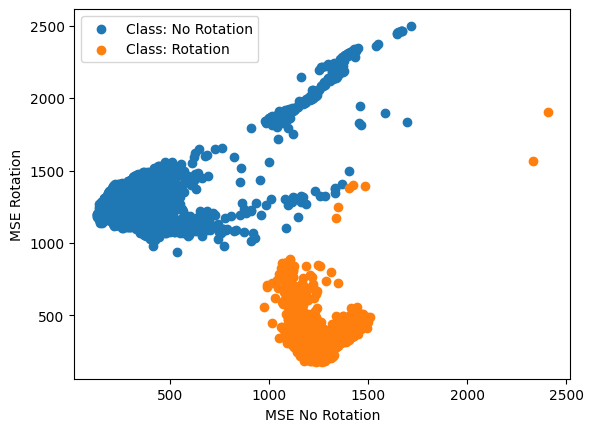

In [225]:
plt.scatter(mse_norot['MSE'].apply(lambda x: x[0]),mse_norot['MSE'].apply(lambda x: x[1]),label = 'Class: No Rotation')
plt.scatter(mse_rot['MSE'].apply(lambda x: x[0]),mse_rot['MSE'].apply(lambda x: x[1]),label = 'Class: Rotation')
# Plot TYPE MSE ROTATIO with VALUE MSE (Y axis)

plt.xlabel('MSE No Rotation')
plt.ylabel('MSE Rotation')
plt.legend()

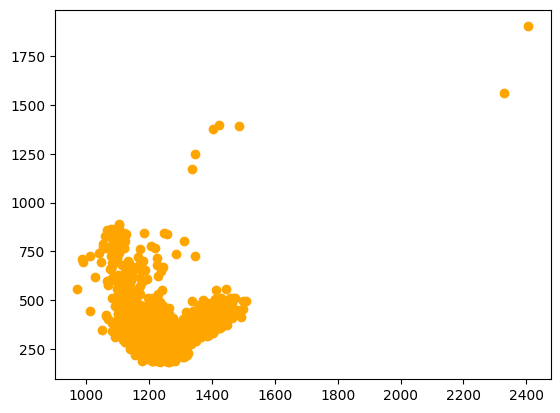

In [226]:
plt.scatter(np.array(mse_rot['MSE'].apply(lambda x: x[0])),np.array(mse_rot['MSE'].apply(lambda x: x[1])),color = 'orange',label = 'Class: Rotation')

# Original Fly Trace

In [227]:
# data source
dat_static ='/media/loganrower/D5E2-7968/20240502125110_data/20240502125110.txt'
os.path.exists('/media/loganrower/D5E2-7968/20240502125110_data/20240502125110.txt')
# female fly heading and led position data
df_fem_static = pd.read_csv(dat_static, names = ['time','fly heading','led position'],sep = " ")

# compute change over time
df_fem_static['delta-t'] = df_fem_static['time'] - df_fem_static['time'][0] 

# compute LED position in degrees
df_fem_static['led angle'] = np.rad2deg(get_LED_angle_in_rad(df_fem_static['led position'])) 

# print(cali_led_pos(df_fem_static))
# print(all_dark_led_pos(df_fem_static))
# print(all_static_led_pos(df_fem_static))
# print(all_loop_led_pos(df_fem_static))
fly_dict = sub_exp_groupv2(df_fem_static)
fly_dict
# get subgroups
# fem_dict_static = sub_exp_group(df_fem_static)
# print(fem_dict_static)
# print(len(fem_dict_static))


{'cali': (0, 6),
 'dark_1': (6, 921),
 'static_1': (921, 2740),
 'static_2': (2740, 4518),
 'static_3': (4518, 6214),
 'static_4': (6214, 7966),
 'dark_2': (7966, 8861)}

Text(0, 0.5, 'Heading/LED Angle')

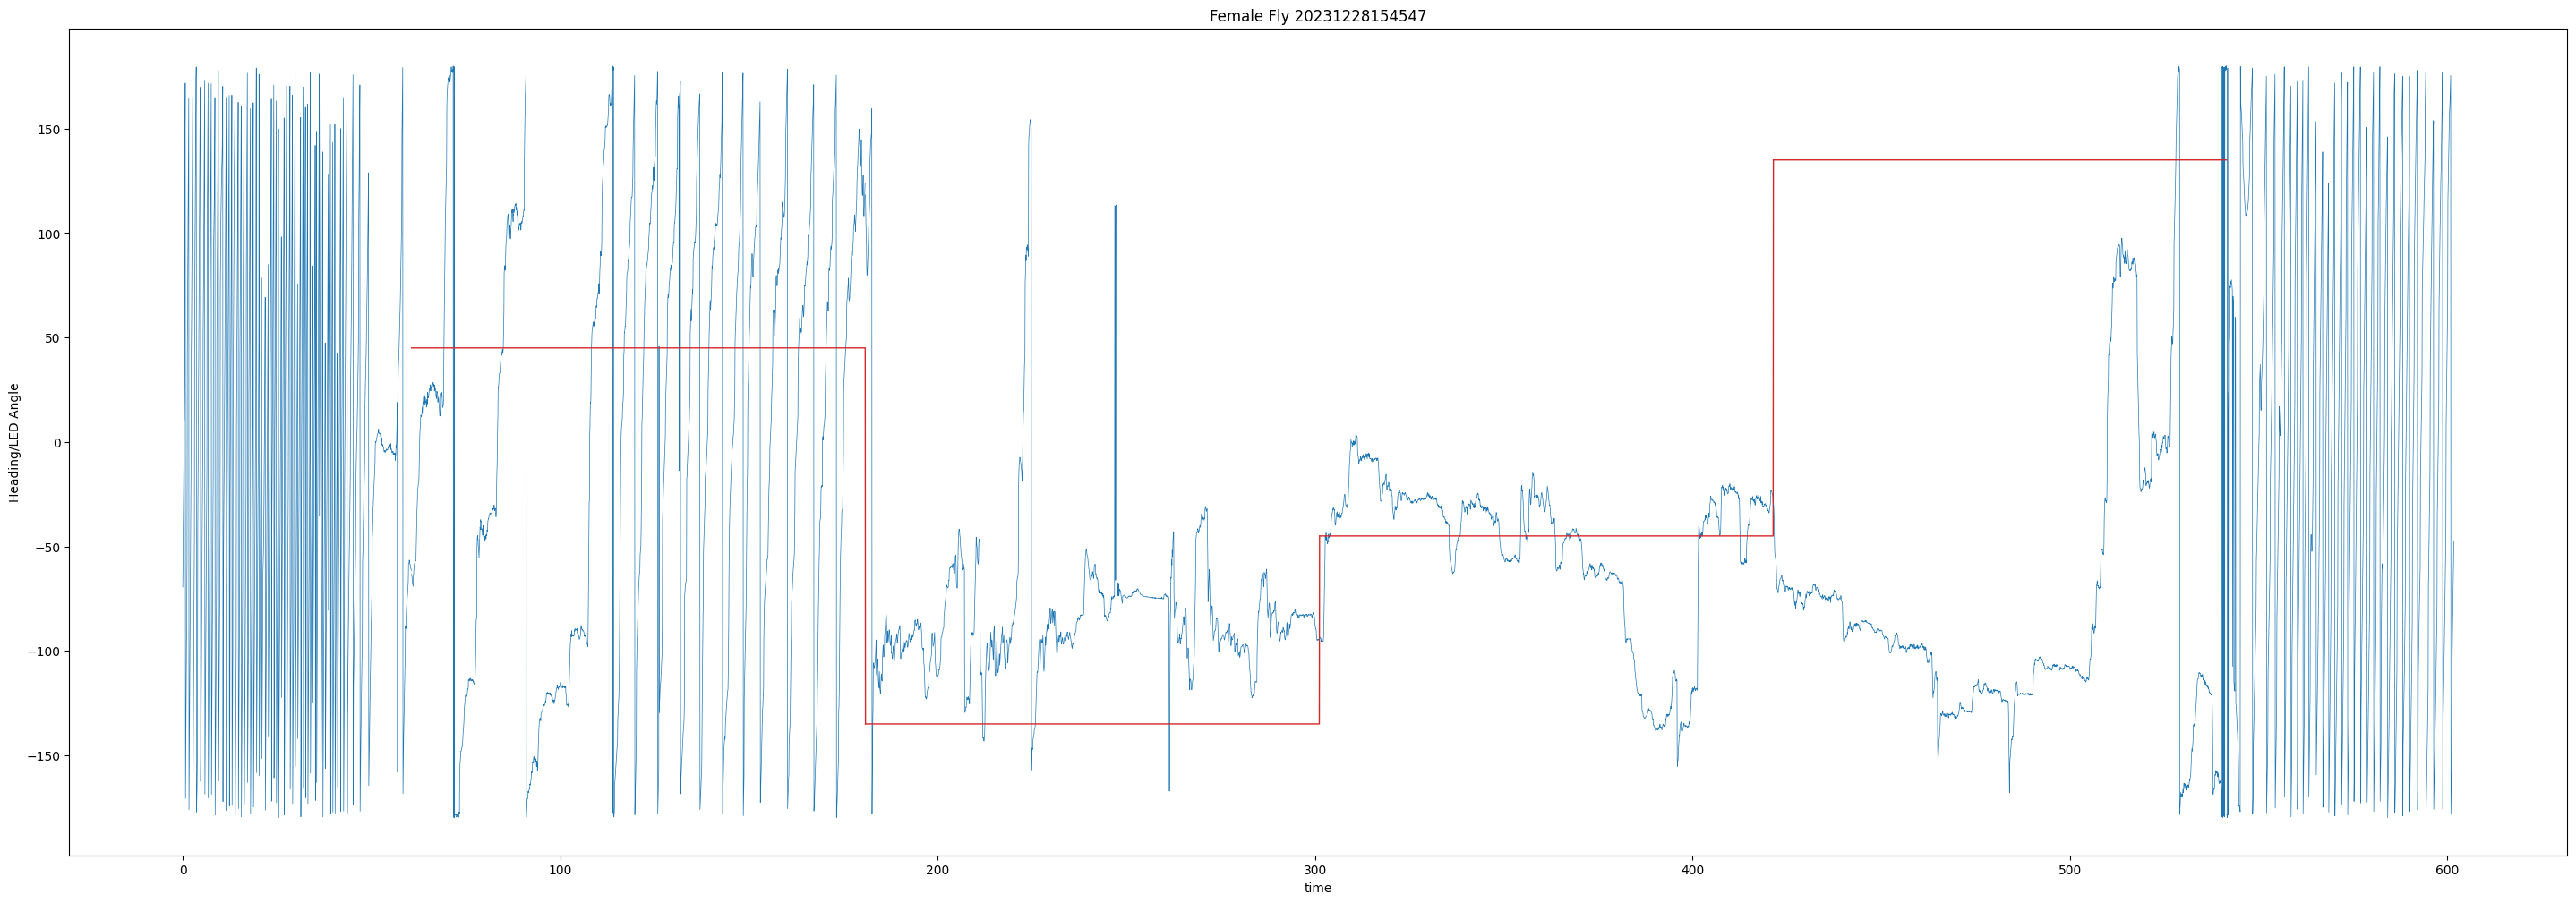

In [228]:
plt.figure(figsize=(36,12))
# iterate over the sections
for k in list(fly_dict.keys()):
    start = fly_dict[k][0]
    end = fly_dict[k][1]
    # print(start,end)
    plt.plot(df_fem_static['delta-t'][start:end],df_fem_static['fly heading'][start:end],color = 'tab:blue', linewidth = .5, label = 'Heading')
    plt.plot(df_fem_static['delta-t'][start:end+1],df_fem_static['led angle'][start:end+1],color = 'tab:red', linewidth = 1, label = 'LED')
plt.title("Female Fly 20231228154547")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")

# Reestablish a new Textfile 
dataframe to textfile

In [229]:
# To the dataframe add the LED positions and the time values from the original textfile...
led_pos = df_fem_static['led position']
time_txt = df_fem_static['time']
results_df = results_df.sort_values(by='file')
results_df =results_df.reset_index(drop = True)
# Sort by time
results_df


file             type  \
0     20240502125110_0001  MSE No Rotation   
1     20240502125110_0002  MSE No Rotation   
2     20240502125110_0003  MSE No Rotation   
3     20240502125110_0004  MSE No Rotation   
4     20240502125110_0005  MSE No Rotation   
...                   ...              ...   
8857  20240502125110_8858  MSE No Rotation   
8858  20240502125110_8859  MSE No Rotation   
8859  20240502125110_8860  MSE No Rotation   
8860  20240502125110_8861  MSE No Rotation   
8861  20240502125110_8862  MSE No Rotation   

                                           MSE  Original Angle  Adjusted Angle  
0      (662.3484944253474, 1451.3111565781255)      110.494410      110.494410  
1      (588.8039388697915, 1456.2091649114582)      122.725043      122.725043  
2       (622.8157349114583, 1442.744037550348)      139.997312      139.997312  
3        (628.616300189236, 1370.926475467014)      152.674577      152.674577  
4      (500.02924546701377, 1408.930289980903)      167.958205      167.958205  
...                                        ...             ...             ...  
8857  (261.76551025868065, 1273.7607749114584)      104.195241      104.195241  
8858    (269.13281275868053, 1285.91897477257)      113.055809      113.055809  
8859    (291.3661351197917, 1293.263465258681)      121.662466      121.662466  
8860   (334.5750994253472, 1267.5805065086806)      132.330784      132.330784  
8861   (298.22672581423615, 1278.424751578125)      140.053228      140.053228  

[8862 rows x 5 columns]

In [230]:
results_df['time'] = time_txt
results_df['led position'] = led_pos
results_df

file             type  \
0     20240502125110_0001  MSE No Rotation   
1     20240502125110_0002  MSE No Rotation   
2     20240502125110_0003  MSE No Rotation   
3     20240502125110_0004  MSE No Rotation   
4     20240502125110_0005  MSE No Rotation   
...                   ...              ...   
8857  20240502125110_8858  MSE No Rotation   
8858  20240502125110_8859  MSE No Rotation   
8859  20240502125110_8860  MSE No Rotation   
8860  20240502125110_8861  MSE No Rotation   
8861  20240502125110_8862  MSE No Rotation   

                                           MSE  Original Angle  \
0      (662.3484944253474, 1451.3111565781255)      110.494410   
1      (588.8039388697915, 1456.2091649114582)      122.725043   
2       (622.8157349114583, 1442.744037550348)      139.997312   
3        (628.616300189236, 1370.926475467014)      152.674577   
4      (500.02924546701377, 1408.930289980903)      167.958205   
...                                        ...             ...   
8857  (261.76551025868065, 1273.7607749114584)      104.195241   
8858    (269.13281275868053, 1285.91897477257)      113.055809   
8859    (291.3661351197917, 1293.263465258681)      121.662466   
8860   (334.5750994253472, 1267.5805065086806)      132.330784   
8861   (298.22672581423615, 1278.424751578125)      140.053228   

      Adjusted Angle          time  led position  
0         110.494410  1.714679e+09            -1  
1         122.725043  1.714679e+09            -1  
2         139.997312  1.714679e+09            -1  
3         152.674577  1.714679e+09            -1  
4         167.958205  1.714679e+09            -1  
...              ...           ...           ...  
8857      104.195241  1.714680e+09           150  
8858      113.055809  1.714680e+09           150  
8859      121.662466  1.714680e+09           149  
8860      132.330784  1.714680e+09           149  
8861      140.053228  1.714680e+09           149  

[8862 rows x 7 columns]

In [231]:
# COUNT NUMBER OF ROTATIONS...
results_df[results_df['type']=='MSE Rotation']

file          type  \
8     20240502125110_0009  MSE Rotation   
9     20240502125110_0010  MSE Rotation   
10    20240502125110_0011  MSE Rotation   
11    20240502125110_0012  MSE Rotation   
12    20240502125110_0013  MSE Rotation   
...                   ...           ...   
8848  20240502125110_8849  MSE Rotation   
8849  20240502125110_8850  MSE Rotation   
8850  20240502125110_8851  MSE Rotation   
8851  20240502125110_8852  MSE Rotation   
8852  20240502125110_8853  MSE Rotation   

                                           MSE  Original Angle  \
8      (1188.077456439236, 393.09289067534723)      131.621384   
9     (1197.0336085920137, 390.67338046701394)      150.512741   
10    (1203.8725097031252, 399.16644081423624)      171.745742   
11     (1225.0335058836808, 416.6864854670138)     -170.636410   
12       (1230.34534477257, 406.3761196336805)     -152.722129   
...                                        ...             ...   
8848   (1296.890286855903, 254.62268866145834)      175.448311   
8849   (1289.2468938003476, 253.2834849809028)     -177.920704   
8850   (1293.2076966475697, 260.1919675503472)     -171.489683   
8851  (1311.5812542864585, 259.42917477256935)     -163.050475   
8852  (1295.4660267864585, 239.63081095312504)     -155.936236   

      Adjusted Angle          time  led position  
8         -48.378616  1.714679e+09           150  
9         -29.487259  1.714679e+09           150  
10         -8.254258  1.714679e+09           150  
11          9.363590  1.714679e+09           150  
12         27.277871  1.714679e+09           150  
...              ...           ...           ...  
8848       -4.551689  1.714680e+09           150  
8849        2.079296  1.714680e+09           150  
8850        8.510317  1.714680e+09           150  
8851       16.949525  1.714680e+09           150  
8852       24.063764  1.714680e+09           150  

[2350 rows x 7 columns]

In [232]:
# Time, Angle, Led Position
# Rewrite
results_df.to_csv('revised_file.txt',sep=' ', header=False)


In [233]:
# data source
data_revised ='revised_file.txt'
# os.path.exists('/media/loganrower/D5E2-7968/20240502125110_data/20240502125110.txt')
# female fly heading and led position data
df_fly_revised= pd.read_csv(data_revised, names = ['filename','type','MSE','Original Angle','Adjusted Angle','time','led position'],sep = " ")

# compute change over time
df_fly_revised['delta-t'] = df_fly_revised['time'] - df_fly_revised['time'][0] 

# compute LED position in degrees
df_fly_revised['led angle'] = np.rad2deg(get_LED_angle_in_rad(df_fly_revised['led position'])) 

# print(cali_led_pos(df_fem_static))
# print(all_dark_led_pos(df_fem_static))
# print(all_static_led_pos(df_fem_static))
# print(all_loop_led_pos(df_fem_static))
fly_dict_revised = sub_exp_groupv2(df_fly_revised)
fly_dict_revised

{'cali': (0, 6),
 'dark_1': (6, 921),
 'static_1': (921, 2740),
 'static_2': (2740, 4518),
 'static_3': (4518, 6214),
 'static_4': (6214, 7966),
 'dark_2': (7966, 8861)}

(-180.0, 180.0)

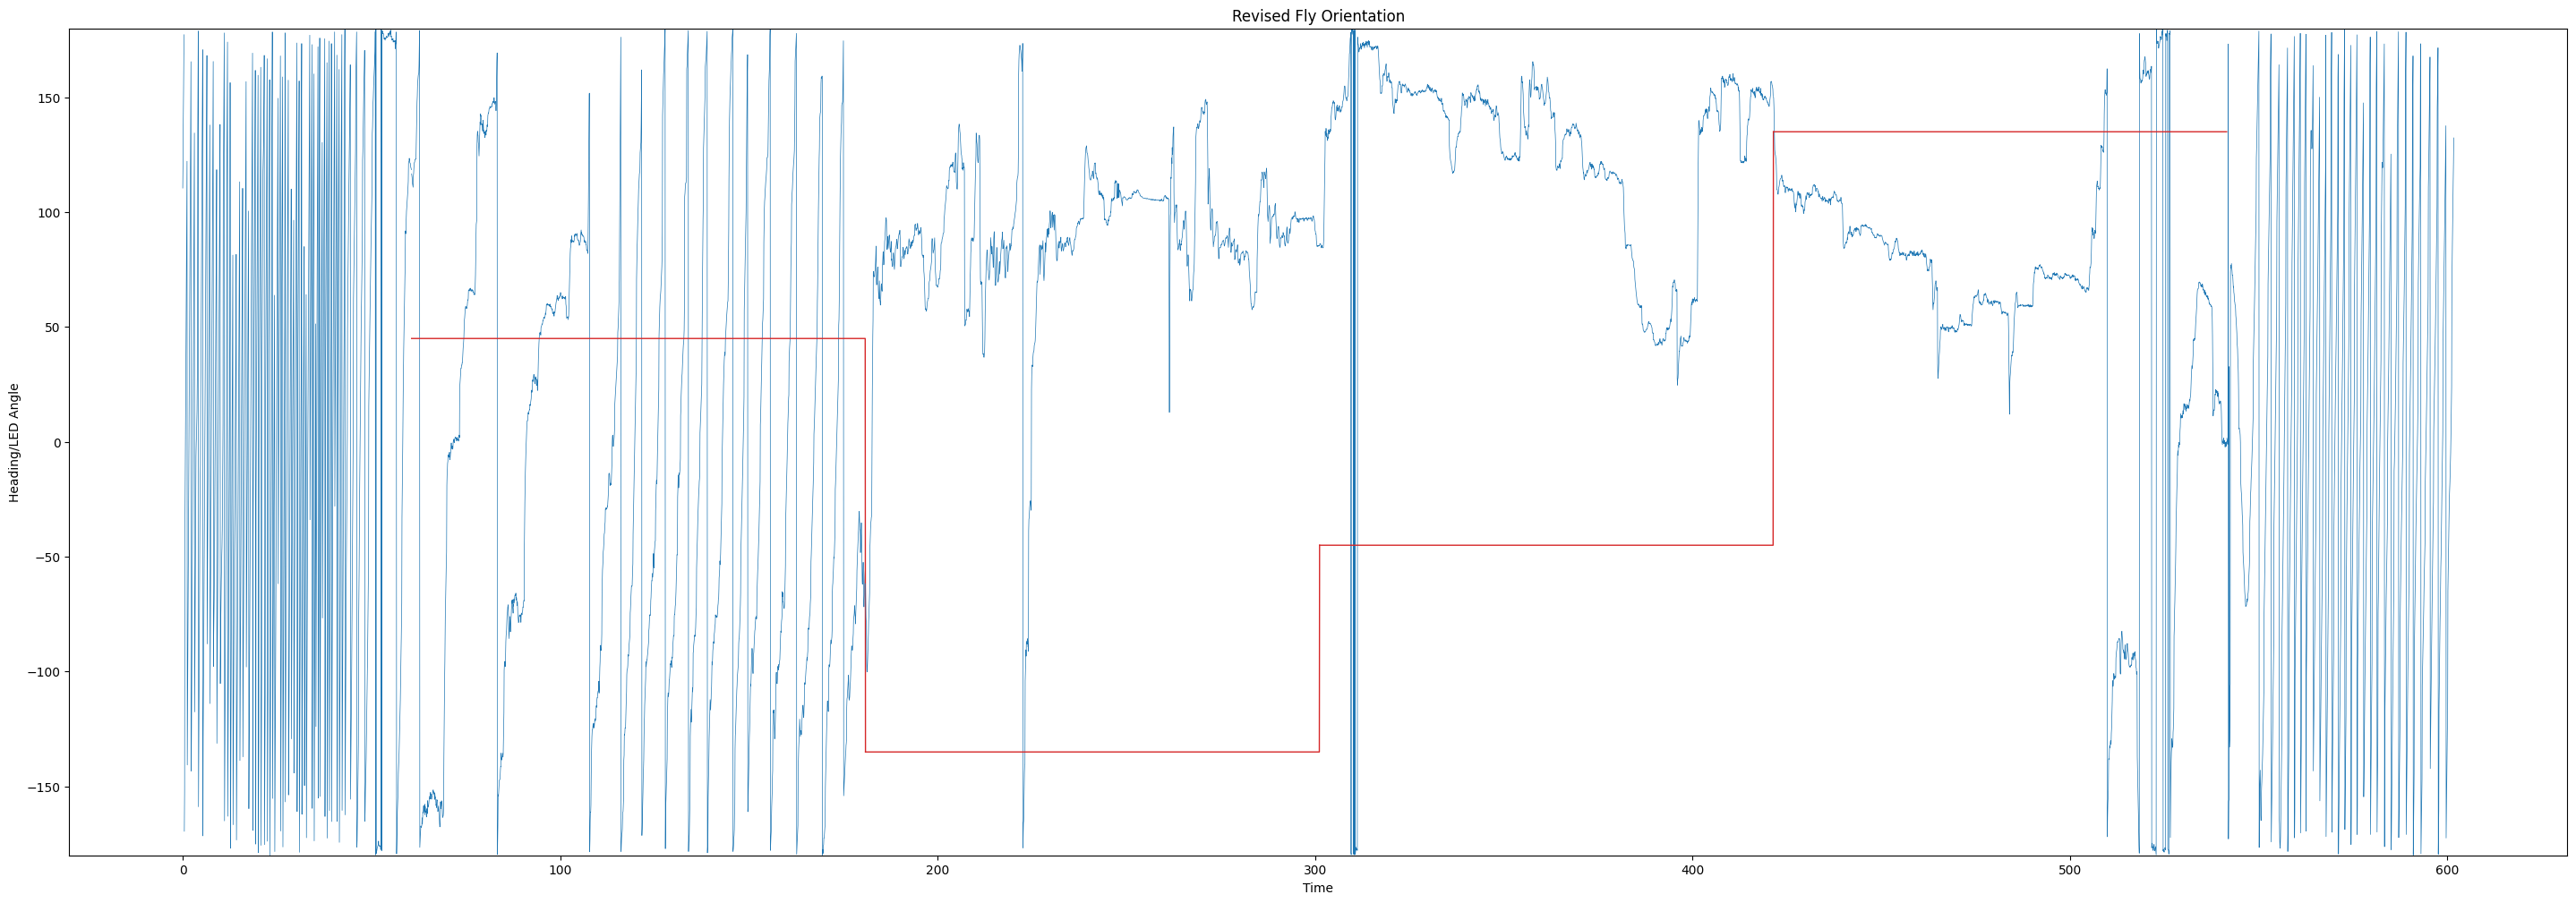

In [234]:
# plotting the revised textfile
plt.figure(figsize=(36,12))
# iterate over the sections
for k in list(fly_dict_revised.keys()):
    start = fly_dict_revised[k][0]
    end = fly_dict_revised[k][1]
    # print(start,end)
    plt.plot(df_fly_revised['delta-t'][start:end],df_fly_revised['Adjusted Angle'][start:end],color = 'tab:blue', linewidth = .5, label = 'Heading')
    plt.plot(df_fly_revised['delta-t'][start:end+1],df_fly_revised['led angle'][start:end+1],color = 'tab:red', linewidth = 1, label = 'LED')
plt.title("Revised Fly Orientation")
plt.xlabel("Time")
plt.ylabel("Heading/LED Angle")
plt.ylim(-180,180)

# New vs Original Plot

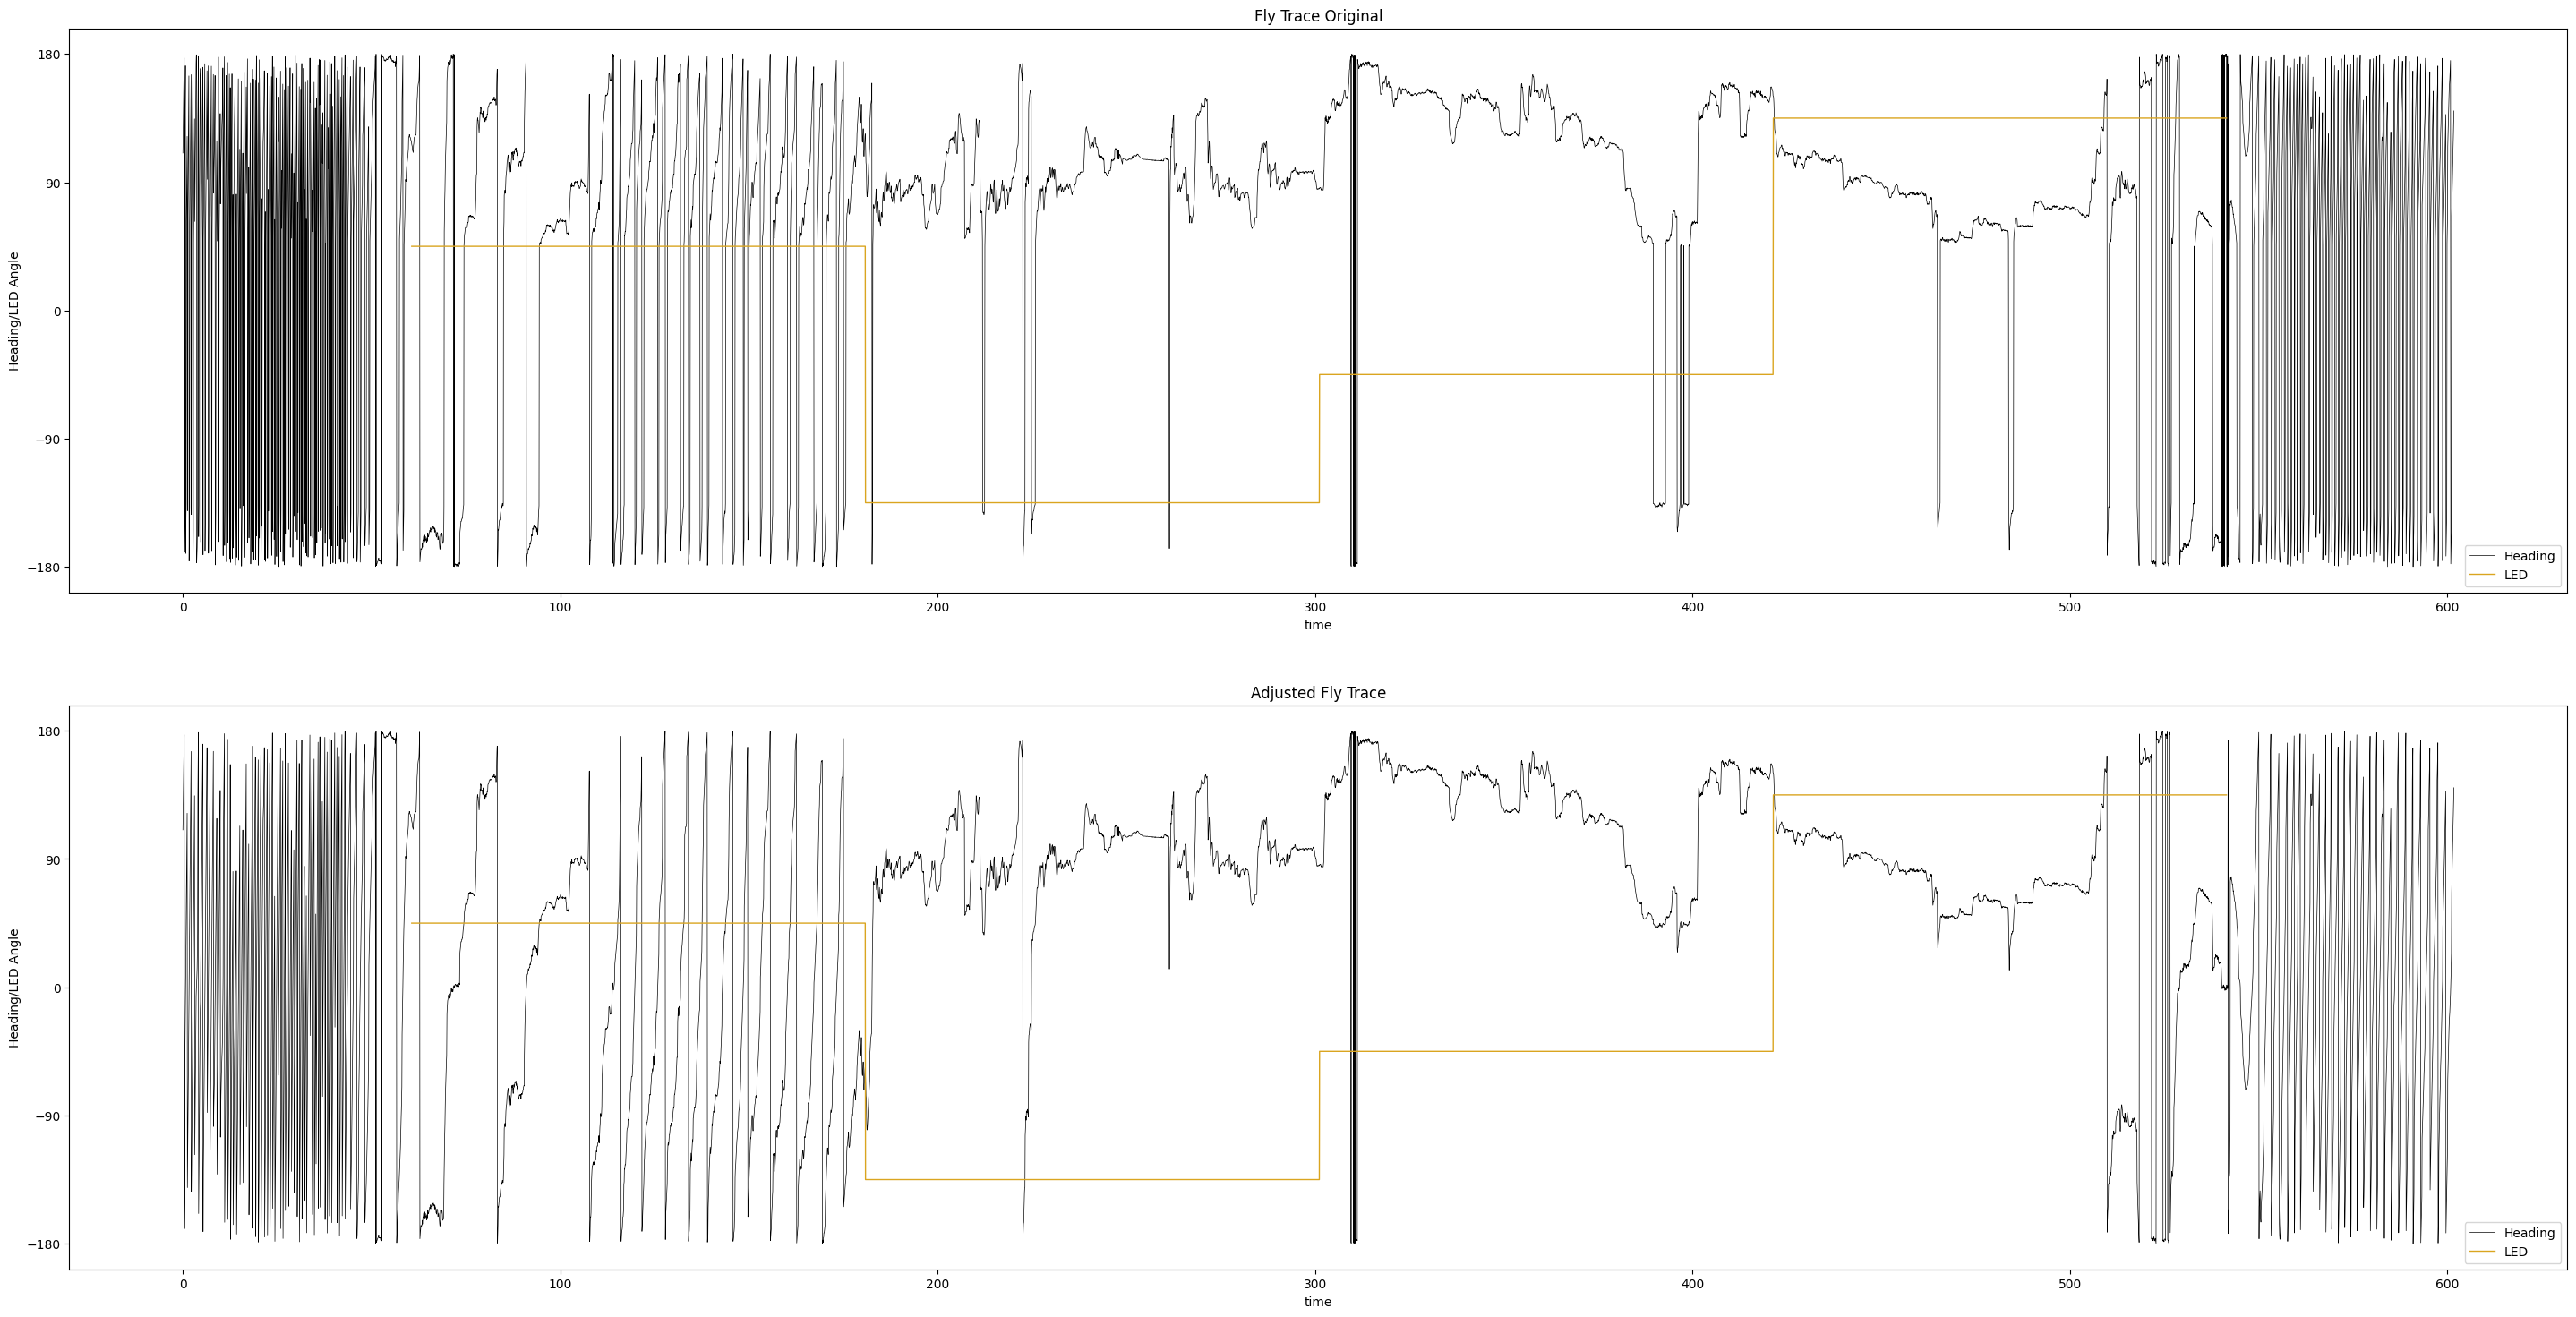

In [246]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(36,18))

# Main Plot 
ax1.plot(df_fly_revised['delta-t'],df_fly_revised['Original Angle'],color = 'k', linewidth = .5, label = 'Heading')
ax1.plot(df_fly_revised['delta-t'],df_fly_revised['led angle'],color = 'goldenrod', linewidth = 1, label = 'LED')
ax1.set_title("Fly Trace Original")
ax1.set_xlabel("time")
ax1.set_ylabel("Heading/LED Angle")
ax1.set_yticks(np.arange(-180,181,90))
ax1.legend(loc = "lower right")

# Offset
ax2.plot(df_fly_revised['delta-t'],df_fly_revised['Adjusted Angle'],color = 'k', linewidth = .5, label = 'Heading')
ax2.plot(df_fly_revised['delta-t'],df_fly_revised['led angle'],color = 'goldenrod', linewidth = 1, label = 'LED')
ax2.set_title("Adjusted Fly Trace")
ax2.set_xlabel("time")
ax2.set_ylabel("Heading/LED Angle")
ax2.set_yticks(np.arange(-180,181,90))
ax2.legend(loc = "lower right")

# Save Figure
plt.savefig('figs/adjvsorig.svg',facecolor = 'white')

# EXTRAS

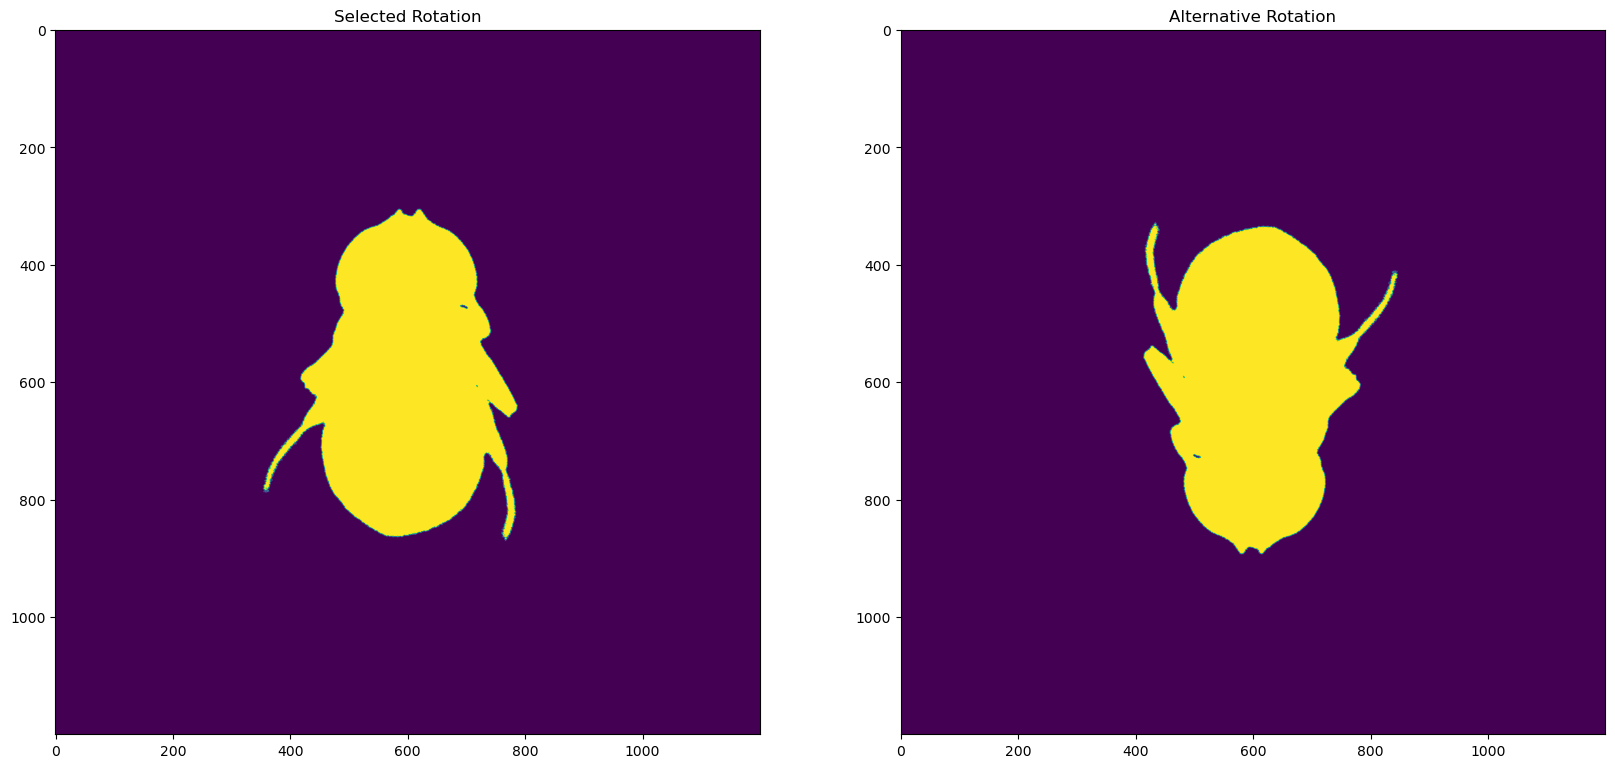

In [42]:
## Test Image (18th image in the stack)
img1 = imgs[list(imgs.keys())[18]].astype('float64')
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title("Selected Rotation")
plt.imshow(img1) 
plt.subplot(122)
plt.title("Alternative Rotation")
plt.imshow(cv2.rotate(img1,cv2.ROTATE_180))

In [43]:
## Comparison between two images
def mse(img1, img2):
    area_px = img1.shape[0]*img1.shape[1]
    px_diff = cv2.subtract(img1, img2)
    sum_err = np.sum(px_diff**2)
    mse = sum_err/(float(area_px))
    return mse
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 255.10822447569433
Rotation: 1138.383849197916


In [20]:
fly_mask_hrz = fly_mask_hrz.astype('float64')
error = mse(avg_mask,fly_mask_hrz)
error2 = mse(avg_mask,cv2.rotate(fly_mask_hrz,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 1946.0575228090283
Rotation: 1709.1743328090274
